In [1]:
import re
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
url = 'https://raw.githubusercontent.com/BarryF710/datasets/main/mie1624_a2_clean_kaggle_data_2022.csv'

#1. Data cleaning

In the data cleaning step, we want to first identify a list of questions that have missing values. Then, for the questions in the missing list, we can either remove the corresponding features if the missing rate is above a certain threshold. Before considering removing the features, it is important to check if the feature is actually significant to the target, or its missingness is due to other factors. After doing the verification, the determined question features will be removed from the dataframe, the corresponding question codes will also be removed from the missing list.

In this survey dataframe, there're generally two types of questions (type-1 and type-2): question with multiple answers (select all that apply) and question with single answer (single selection, short answer). The first type of question is splitted into several sub columns, for example, Q6_1 to Q6_12. Each sub column of the question represents an option of the question. That means the first type of question can be easily encoded using one hot encoding. For the type-1 question without missing value, we can first fill NaN with 'Unknown', then apply one hot encoding.
For the type-1 question with missing value, we can:

*   drop the question features IF its missing rate is higher than the threshold AND the question is not relevant to the target to be predicted
*   fill NaN with 'Unknown' before one hot encoding IF its missing rate is below the threshold/it's relevant to the target AND its missingness is due to other factors, e.g., the user can answer Q43 only if the user answers Q15
*   apply appropriate imputation methods before one hot encoding IF its missing rate is below the threshold/it's relevant to the target AND its missingness is naturally caused, e.g., the user can answer Q44 without any restrictions but does not answer it

The second type of question has only one column. For the type-2 question without missing value, we can keep it as is.
Similar to the above, for the type-2 question with missing value, we can:
*   drop the question features IF its missing rate is higher than the threshold AND the question is not relevant to the target to be predicted
*   fill NaN with 'Unknown' then treat it as a different class when encoding IF its missing rate is below the threshold/it's relevant to the target AND its missingness is due to other factors
*   apply appropriate imputation methods before encoding IF its missing rate is below the threshold/it's relevant to the target AND its missingness is naturally caused



In [2]:
data = pd.read_csv(url,dtype={'Duration (in seconds)': str},encoding='unicode_escape') # read the dataset
data_detail = data.loc[0,:] # store the description for each question and its options
data = data.drop(0) # delete the details of the questions
data = data.reset_index(drop=True) # reset index
pd.set_option('display.max_columns', 1000) # let df to display the full columns
data.loc[0:4,:] # show 5 rows of the dataset

,Duration (in seconds),Q2,Q3,Q4,Q5,Q6_1,Q6_2,Q6_3,Q6_4,Q6_5,Q6_6,Q6_7,Q6_8,Q6_9,Q6_10,Q6_11,Q6_12,Q7_1,Q7_2,Q7_3,Q7_4,Q7_5,Q7_6,Q7_7,Q8,Q9,Q10_1,Q10_2,Q10_3,Q11,Q12_1,Q12_2,Q12_3,Q12_4,Q12_5,Q12_6,Q12_7,Q12_8,Q12_9,Q12_10,Q12_11,Q12_12,Q12_13,Q12_14,Q12_15,Q13_1,Q13_2,Q13_3,Q13_4,Q13_5,Q13_6,Q13_7,Q13_8,Q13_9,Q13_10,Q13_11,Q13_12,Q13_13,Q13_14,Q14_1,Q14_2,Q14_3,Q14_4,Q14_5,Q14_6,Q14_7,Q14_8,Q14_9,Q14_10,Q14_11,Q14_12,Q14_13,Q14_14,Q14_15,Q14_16,Q15_1,Q15_2,Q15_3,Q15_4,Q15_5,Q15_6,Q15_7,Q15_8,Q15_9,Q15_10,Q15_11,Q15_12,Q15_13,Q15_14,Q15_15,Q16,Q17_1,Q17_2,Q17_3,Q17_4,Q17_5,Q17_6,Q17_7,Q17_8,Q17_9,Q17_10,Q17_11,Q17_12,Q17_13,Q17_14,Q17_15,Q18_1,Q18_2,Q18_3,Q18_4,Q18_5,Q18_6,Q18_7,Q18_8,Q18_9,Q18_10,Q18_11,Q18_12,Q18_13,Q18_14,Q19_1,Q19_2,Q19_3,Q19_4,Q19_5,Q19_6,Q19_7,Q19_8,Q20_1,Q20_2,Q20_3,Q20_4,Q20_5,Q20_6,Q21_1,Q21_2,Q21_3,Q21_4,Q21_5,Q21_6,Q21_7,Q21_8,Q21_9,Q21_10,Q22,Q23,Q24,Q25,Q26,Q27,Q28_1,Q28_2,Q28_3,Q28_4,Q28_5,Q28_6,Q28_7,Q28_8,Q29,Q30,Q31_1,Q31_2,Q31_3,Q31_4,Q31_5,Q31_6,Q31_7,Q31_8,Q31_9,Q31_10,Q31_11,Q31_12,Q32,Q33_1,Q33_2,Q33_3,Q33_4,Q33_5,Q34_1,Q34_2,Q34_3,Q34_4,Q34_5,Q34_6,Q34_7,Q34_8,Q35_1,Q35_2,Q35_3,Q35_4,Q35_5,Q35_6,Q35_7,Q35_8,Q35_9,Q35_10,Q35_11,Q35_12,Q35_13,Q35_14,Q35_15,Q35_16,Q36_1,Q36_2,Q36_3,Q36_4,Q36_5,Q36_6,Q36_7,Q36_8,Q36_9,Q36_10,Q36_11,Q36_12,Q36_13,Q36_14,Q36_15,Q37_1,Q37_2,Q37_3,Q37_4,Q37_5,Q37_6,Q37_7,Q37_8,Q37_9,Q37_10,Q37_11,Q37_12,Q37_13,Q38_1,Q38_2,Q38_3,Q38_4,Q38_5,Q38_6,Q38_7,Q38_8,Q39_1,Q39_2,Q39_3,Q39_4,Q39_5,Q39_6,Q39_7,Q39_8,Q39_9,Q39_10,Q39_11,Q39_12,Q40_1,Q40_2,Q40_3,Q40_4,Q40_5,Q40_6,Q40_7,Q40_8,Q40_9,Q40_10,Q40_11,Q40_12,Q40_13,Q40_14,Q40_15,Q41_1,Q41_2,Q41_3,Q41_4,Q41_5,Q41_6,Q41_7,Q41_8,Q41_9,Q42_1,Q42_2,Q42_3,Q42_4,Q42_5,Q42_6,Q42_7,Q42_8,Q42_9,Q43,Q44_1,Q44_2,Q44_3,Q44_4,Q44_5,Q44_6,Q44_7,Q44_8,Q44_9,Q44_10,Q44_11,Q44_12,Q29_Encoded,Q29_buckets
0,851,55-59,Man,France,No,Coursera,NaN,Kaggle Learn Courses,NaN,NaN,NaN,Udemy,NaN,NaN,NaN,NaN,Other,NaN,"Online courses (Coursera, EdX, etc)",NaN,NaN,"Kaggle (notebooks, competitions, etc)",NaN,NaN,Some college/university study without earning ...,NaN,NaN,NaN,NaN,10-20 years,Python,NaN,SQL,NaN,NaN,NaN,NaN,NaN,Bash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Visual Studio Code (VSCode),NaN,NaN,NaN,Sublime Text,Vim / Emacs,NaN,Jupyter Notebook,NaN,NaN,NaN,Kaggle Notebooks,Colab Notebooks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Deepnote Notebooks,NaN,NaN,NaN,Matplotlib,Seaborn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1-2 years,Scikit-learn,NaN,NaN,PyTorch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Huggingface,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Transformer Networks (BERT, gpt-3, etc)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,"Word embeddings/vectors (GLoVe, fastText, word...","Encoder-decoder models (seq2seq, vanilla trans...",NaN,"Transformer language models (GPT-3, BERT, XLne...",NaN,NaN,NaN,NaN,Huggingface Models,NaN,NaN,ONNX models,NaN,NaN,NaN,Other storage services (i.e. google drive),Huggingface Models,Data Scientist,Online Service/Internet-based Services,0-49 employees,2-Jan,"We recently started using ML methods (i.e., mo...",NaN,NaN,Build prototypes to explore applying machine l...,Build and/or run a machine learning service th...,Experimentation and iteration to improve exist...,NaN,NaN,NaN,"25,000-29,999","$1000-$9,999",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MongoDB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No / None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No / None,NaN,NaN,NaN,ONNX Runtime,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Weights & Biases,NaN,TensorBoard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,GPUs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2-5 times,Twitter (data science influencers),NaN,NaN,"Kaggle (notebooks, forums, etc)","Course Forums (forums.fast.ai, Coursera forums...",NaN,NaN,"Blogs (Towards Data Sc

In [3]:
data1 = data.copy()
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
missing = data1.isnull().mean() # check the percentage of missing values per variable
unique_names = missing.index.map(lambda x: re.sub(r'(_\d+)?$', '', x)).unique() # get the unique question number
print('The questions in this survey are:')
print(list(unique_names)) # a list of question numbers in this survey
missing = missing[missing != 0] # get all the columns with missing values and its missing percentage
unique_missing_names = missing.index.map(lambda x: re.sub(r'(_\d+)?$', '', x)).unique() # get the unique question number
print('The primary list of questions that have missing values are:') # here, if one column has NaN entry, the related question is considered as having missing value. For example, if col 'Q42_1' has NaN entry, we say 'Q42' has missing value
print(list(unique_missing_names)) # a list of question numbers that have missing value

The questions in this survey are:
['Duration (in seconds)', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27', 'Q28', 'Q29', 'Q30', 'Q31', 'Q32', 'Q33', 'Q34', 'Q35', 'Q36', 'Q37', 'Q38', 'Q39', 'Q40', 'Q41', 'Q42', 'Q43', 'Q44', 'Q29_Encoded', 'Q29_buckets']
The primary list of questions that have missing values are:
['Q6', 'Q7', 'Q9', 'Q10', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21', 'Q22', 'Q28', 'Q30', 'Q31', 'Q32', 'Q33', 'Q34', 'Q35', 'Q36', 'Q37', 'Q38', 'Q39', 'Q40', 'Q41', 'Q42', 'Q43', 'Q44']


In [4]:
print('Description of each question in the survey:')
for feature in unique_names:
  try:
    des = data_detail[feature]
  except KeyError:
    des = data_detail[feature+'_1']
  print(str(feature)+' description: '+str(des)+'\n')

Description of each question in the survey:
Duration (in seconds) description: Duration (in seconds)

Q2 description: What is your age (# years)?

Q3 description: What is your gender? - Selected Choice

Q4 description: In which country do you currently reside?

Q5 description: Are you currently a student? (high school, university, or graduate)

Q6 description: On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - Coursera

Q7 description: What products or platforms did you find to be most helpful when you first started studying data science?  (Select all that apply) - Selected Choice - University courses

Q8 description: What is the highest level of formal education that you have attained or plan to attain within the next 2 years?

Q9 description: Have you ever published any academic research (papers, preprints, conference proceedings, etc)?

Q10 description: Did your research make use of machine learning? - Yes, the research m

In [5]:
missing_adj = pd.Series(dtype=np.float64) # to store the adjusted missing col and its missing percentage
for name in unique_missing_names: # here, we say if user select at least one option, then that question actually does not have missing value
  Q_num = name # "Q#"
  cols = [col for col in data1 if col.startswith(Q_num)] # get all columns start with "Q#"
  rows_with_all_nan = data1[cols].isna().all(axis=1) # get the row where all columns start with "Q#" have missing value
  num_rows_with_all_nan = rows_with_all_nan.sum() # count the total number of rows
  total_rows = data1.shape[0] # count the total number of rows of the data
  percentage = num_rows_with_all_nan/total_rows # calculate the missing percentage
  missing_adj[Q_num] = percentage # add the value to the corresponding question id

print('The questions that do not really have missing values are:')
print(missing_adj[missing_adj == 0].index.to_list())
print('This means, in Q6 and Q28, at least one option is selected by the user, so they should not be considered as having missing value.\n')
print('After removing Q6 and Q28 from the missing list:')
missing_adj = missing_adj[missing_adj != 0].sort_values(ascending=False) # the list is sorted by the missing percentage
print(missing_adj.index.to_list())

threshold = 0.5 # set up the missing value percentage threshold

print('Remove the features that have missing rate greater than',threshold)
removed_feature = missing_adj[missing_adj > threshold].index.to_list()
print('The features to be removed are:',removed_feature,'\n')

missing_adj  = missing_adj[missing_adj <= threshold]
print('Now, the missing list are:')
print(missing_adj.index.to_list())

The questions that do not really have missing values are:
['Q6', 'Q28']
This means, in Q6 and Q28, at least one option is selected by the user, so they should not be considered as having missing value.

After removing Q6 and Q28 from the missing list:
['Q22', 'Q32', 'Q20', 'Q10', 'Q19', 'Q34', 'Q33', 'Q43', 'Q42', 'Q41', 'Q40', 'Q39', 'Q38', 'Q37', 'Q36', 'Q35', 'Q31', 'Q9', 'Q18', 'Q21', 'Q17', 'Q15', 'Q14', 'Q13', 'Q12', 'Q16', 'Q44', 'Q30', 'Q7']
Remove the features that have missing rate greater than 0.5
The features to be removed are: ['Q22', 'Q32', 'Q20', 'Q10', 'Q19', 'Q34', 'Q33'] 

Now, the missing list are:
['Q43', 'Q42', 'Q41', 'Q40', 'Q39', 'Q38', 'Q37', 'Q36', 'Q35', 'Q31', 'Q9', 'Q18', 'Q21', 'Q17', 'Q15', 'Q14', 'Q13', 'Q12', 'Q16', 'Q44', 'Q30', 'Q7']


In this missing list, the questions that have more than 50% missing rate are: Q22, Q32, Q20, Q10, Q19, Q34, Q33.

Let's review their question description:

Q22 description: Which of the following ML model hubs/repositories do you use most often?

Q32 description: Of the cloud platforms that you are familiar with, which has the best developer experience (most enjoyable to use)?

Q20 description: Which of the following natural language processing (NLP) methods do you use on a regular basis?  (Select all that apply)

Q10 description: Did your research make use of machine learning?

Q19 description: Which categories of computer vision methods do you use on a regular basis?  (Select all that apply)

Q34 description: Do you use any of the following data storage products? (Select all that apply)

Q33 description: Do you use any of the following cloud computing products? (Select all that apply)

We can see from the format of the survey that most of the missingness is due to the constrained question, i.e., only those users who meet certain conditions can answer the question. Therefore, dropping this kinds of features may cause information loss, which may affect the rationality and the performance of the machine learning model. However, I decide to drop these features for the following reason:

*   these questions are not closely related to the target, the yearly compensation, because they focus on very specific aspects of the data science topic, which may not represent the general machine learning data scientist
*   according to assignment 2, we may choose a subset of data with a sample size no fewer than 5000, which requires 61% (5000/8136) of the data. In this case, these features may not satisfy the minimum requirement of training a model

Therefore, I decide to remove these features in the data cleaning phase.

In [6]:
#here, we define some useful functions
def fill_na(df,Q_col,filler): # given a dataframe df, fill the NaN in columns Q_col with the filler
  df[Q_col] = df[Q_col].fillna(filler)
  return df

def get_col(df,Q_num): # get the columns related to a certain question
  Q_col = [col for col in df if col.startswith(Q_num)]
  return Q_col

def get_unique(df,df_col,filler): # given a dataframe df with columns Q_col, get the unique entries
  unique_entries = []
  for col in df_col:
    unique_entries.extend(df[col].unique()) # get unique entries in columns Q_col
  unique_entries = [entry for entry in set(unique_entries) if entry != filler] # filter out the filler if we want
  return unique_entries

def get_frequency(df,unique_entries,df_col): # given a dataframe df with columns Q_col, get the frequency of each entry in unique_entries
  value_counts = {}
  for col in df_col:
    for value in unique_entries:
      count = (df[col] == value).sum()  # number of times of each unique value shows in each column
      if value in value_counts:
        value_counts[value] += count # add the total counts to the corresponding language
      else:
        value_counts[value] = count
  return value_counts

def freq_oneh_encode(freq_dict): # given the frequency counts, generate encoding labels for the frequency encoding case and the one-hot encoding case
  freq_dict = freq_dict
  sorted_freq = sorted(freq_dict.items(), key=lambda x: x[1])
  freq_encode = {var: label + 1 for label, (var, _) in enumerate(sorted_freq)} # the entry with higer frequency will get a higher numerical label
  oneh_encode = {key: 1 for key in freq_encode.keys()} # every entry gets the numerical label of 1
  return freq_encode,oneh_encode

def remove_feature(df,removed_feature):
  for name in removed_feature:
    Q_num = name # "Q#"
    cols = [col for col in df if col.startswith(Q_num)] # get all columns start with "Q#"
    df = df.drop(columns=cols) # delete the corresponding columns
  return df

def mode_multi_col(df,Q_col,col_fill,filler):
  all_nan = df[Q_col].isna().all(axis=1)
  df.loc[all_nan, col_fill] = filler
  return df

In [7]:
#here, we remove feature columns for these questions: ['Q22', 'Q32', 'Q20', 'Q10', 'Q19', 'Q34', 'Q33']
data = remove_feature(data,removed_feature)

In [8]:
multi_missing_adj_list = []
for Q_num in missing_adj.index.to_list():
  Q_col = get_col(data,Q_num)
  if len(Q_col) > 1:
    multi_missing_adj_list.append(Q_num)
print('The type-1 questions in the missing list after feature removal are:',multi_missing_adj_list)

The type-1 questions in the missing list after feature removal are: ['Q42', 'Q41', 'Q40', 'Q39', 'Q38', 'Q37', 'Q36', 'Q35', 'Q31', 'Q18', 'Q21', 'Q17', 'Q15', 'Q14', 'Q13', 'Q12', 'Q44', 'Q7']


For the remaining questions in the missing list, the type-1 questions (multi column), type_1_constrained questions have missing values due to other factors (constrained question), type_1_natural questions have missing values due to the natural cause. So, we fill NaN with 'Unknown' before one hot encoding for type_1_constrained questions. For type_1_natural questions, we apply mode imputation then fill NaN with 'Unknown'.

In [9]:
type_1_constrained = ['Q42', 'Q41', 'Q40', 'Q39', 'Q38', 'Q37', 'Q36', 'Q35', 'Q31', 'Q18', 'Q21', 'Q17', 'Q15', 'Q14', 'Q13', 'Q12']
type_1_natural = ['Q44', 'Q7']

for Q_num in type_1_constrained: # for each type-1 constrained question
  Q_col = get_col(data,Q_num)
  data = fill_na(data,Q_col,'Unknown') # fill NaN with a new variable 'Unknown' to represent the missingness

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128 (\x80) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


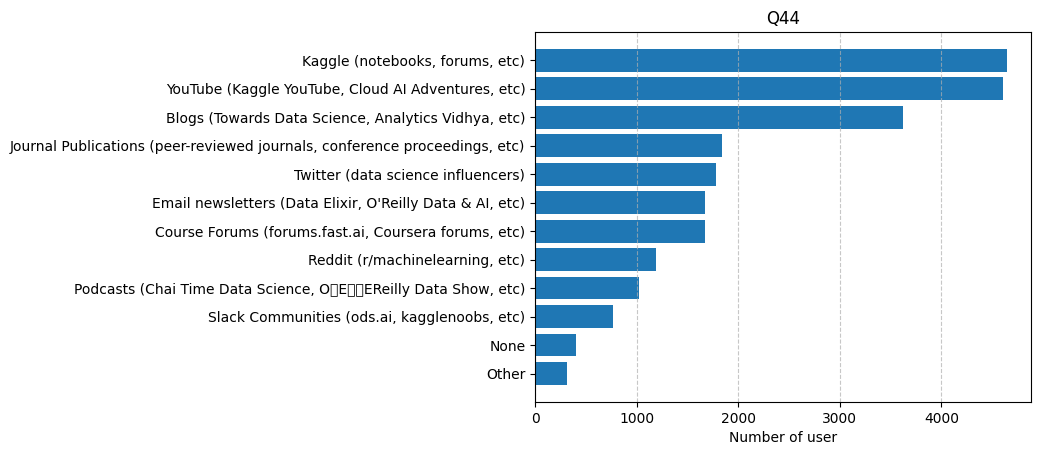

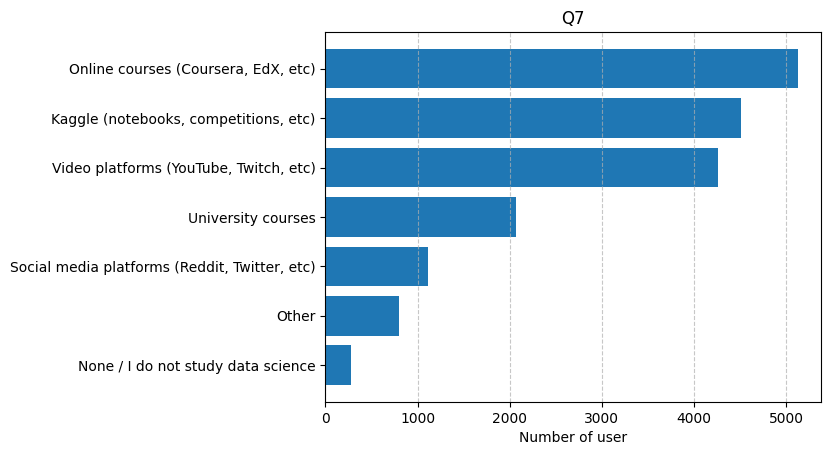

In [10]:
#plot histogram for Q44 and Q7

def plot_barh(data,Q_num,is_multi=True): # copied from previous assignment
  if is_multi:
    Q12_col = [col for col in data if col.startswith(Q_num)] # find all columns related to Q
  else:
    Q12_col = [Q_num]
  unique_languages = []
  for col in Q12_col:
    unique_languages.extend(data[col].unique())
  unique_values = list(set(unique_languages)) # find unique value
  unique_values = [x for x in unique_values if x == x] # drop nan

  language_counts = {}
  for col in Q12_col:
    for value in unique_values:
      count = (data[col] == value).sum()  # number of times of each unique value shows in each column
      if value in language_counts:
        language_counts[value] += count # add the total counts to the corresponding category
      else:
        language_counts[value] = count

  language_counts_sort = sorted(language_counts.items(), key=lambda x:x[1], reverse=False) # sort the number of users per each value
  bar_name = [item[0] for item in language_counts_sort] # collect bar names
  bar_value = [item[1] for item in language_counts_sort] # collect the corresponding value

  plt.barh(range(len(bar_name)), bar_value) # horizontal bar plot
  plt.yticks(range(len(bar_name)), bar_name)
  plt.title(Q_num)
  plt.xlabel('Number of user')
  plt.grid(axis='x', linestyle='--', alpha=0.7)
  plt.show()

plot_barh(data1,'Q44')
plot_barh(data1,'Q7')

In [11]:
#let's get the unique entries in Q44 and Q7
Q44_col = get_col(data,'Q44')
Q44_entires = get_unique(data,Q44_col,'')
Q7_col = get_col(data,'Q7')
Q7_entires = get_unique(data,Q7_col,'')
print('Q44 categories are:')
print(Q44_entires)
print('Q7 categories are:')
print(Q7_entires)

Q44 categories are:
['Twitter (data science influencers)', 'None', 'Reddit (r/machinelearning, etc)', 'Podcasts (Chai Time Data Science, O\x81E\x80\x81EReilly Data Show, etc)', 'Slack Communities (ods.ai, kagglenoobs, etc)', "Email newsletters (Data Elixir, O'Reilly Data & AI, etc)", 'YouTube (Kaggle YouTube, Cloud AI Adventures, etc)', 'Other', 'Journal Publications (peer-reviewed journals, conference proceedings, etc)', 'Kaggle (notebooks, forums, etc)', 'Blogs (Towards Data Science, Analytics Vidhya, etc)', nan, 'Course Forums (forums.fast.ai, Coursera forums, etc)']
Q7 categories are:
['Online courses (Coursera, EdX, etc)', 'None / I do not study data science', 'Video platforms (YouTube, Twitch, etc)', 'University courses', 'Other', 'Kaggle (notebooks, competitions, etc)', 'Social media platforms (Reddit, Twitter, etc)', nan]


In [12]:
#Q44 has a missing rate of 3.5%, Q7 has a missing rate of 0.012% --> mode imputation (replace NaN by the most frequent variable)
#for Q44 and Q7, we apply mode imputation before filling NaN with 'Unknown'

data = mode_multi_col(data,Q44_col,'Q44_4','Kaggle (notebooks, forums, etc)') # apply mode imputation on Q44
data = mode_multi_col(data,Q7_col,'Q7_2','Online courses (Coursera, EdX, etc)') # apply mode imputation on Q7
data = fill_na(data,Q44_col,'Unknown') # fill NaN with a new variable 'Unknown'
data = fill_na(data,Q7_col,'Unknown') # fill NaN with a new variable 'Unknown'

In [13]:
single_missing_adj_list = []
for Q_num in missing_adj.index.to_list():
  Q_col = get_col(data,Q_num)
  if len(Q_col) == 1:
    single_missing_adj_list.append(Q_num)
print('The type-2 questions in the missing list after feature removal are:',single_missing_adj_list)

The type-2 questions in the missing list after feature removal are: ['Q43', 'Q9', 'Q16', 'Q30']


For the remaining questions in the missing list, the type-2 questions (single column). All of them are constrained. So, we simply fill NaN with 'Unknown' before encoding.

In [14]:
type_2_constrained = ['Q43', 'Q9', 'Q16', 'Q30']

for Q_num in type_2_constrained: # for each type-1 constrained question
  Q_col = get_col(data,Q_num)
  data = fill_na(data,Q_col,'Unknown') # fill NaN with a new variable 'Unknown' to represent the missingness

Lastly, let's handle the question features without missing value. As is mentioned above, we simply fill NaN with 'Unknown' for the type-1 (multi-col) questions without missing value.

In [15]:
full_Q_list = ['Duration (in seconds)', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27', 'Q28', 'Q29', 'Q30', 'Q31', 'Q32', 'Q33', 'Q34', 'Q35', 'Q36', 'Q37', 'Q38', 'Q39', 'Q40', 'Q41', 'Q42', 'Q43', 'Q44', 'Q29_Encoded', 'Q29_buckets']
missing_Q_list = ['Q43', 'Q42', 'Q41', 'Q40', 'Q39', 'Q38', 'Q37', 'Q36', 'Q35', 'Q31', 'Q9', 'Q18', 'Q21', 'Q17', 'Q15', 'Q14', 'Q13', 'Q12', 'Q16', 'Q44', 'Q30', 'Q7']
removed_Q_list = ['Q22', 'Q32', 'Q20', 'Q10', 'Q19', 'Q34', 'Q33']
handled_Q_list = missing_Q_list + removed_Q_list # the question features we've already processed
non_missing_Q_list = [q for q in full_Q_list if q not in handled_Q_list] # the question features we haven't looked at

for Q_num in non_missing_Q_list: # for each question without missing value
  Q_col = get_col(data,Q_num)
  if len(Q_col) > 1: # if the question is type-1 (multi-col)
    data = fill_na(data,Q_col,'Unknown') # fill NaN with a new variable 'Unknown'

*Appendix for part 1*

more than 80% missing rate:

Q22:    (Q20 selected count > 1)

less than 80% missing rate:

Q32:    (Q30 selected count > 0)

Q20:    (Q15 > 0 and Q17 = RNN or Transformer)

less than 70% missing rate:

Q10:    (Q8 = Yes)

Q19:    (Q15 > 0 and Q17 = CNN, GAN, or Transformer)

less than 60% missing rate:

Q34:    (Q30 = AWS, Azure, or GCP)

Q33:    (Q30 = AWS, Azure, or GCP)

less than 50% missing rate:

Q43:    (Q29>0 and Q15>0)

Q42:    (Q29>0 and Q15>0)

Q41:    (Q29>0 and Q15>0)

Q40:    (Q29>0 and Q15>0)

Q39:    (Q29>0 and Q15>0)

Q38:    (Q29>0 and Q15>0)

Q37:    (Q29>0 and Q15>0)

less than 40% missing rate:

Q36:    (Q29>0)

Q35:    (Q29>0)

Q31:    (Q29>0)

Q9:     (Q7 > Bachelor's)

less than 25% missing rate:

Q18:    (Q15>0)

Q21:    (Q15>0)

Q17:    (Q15>0)

less than 10% missing rate:

Q15:    (Q10>0)

Q14:    (Q10>0)

Q13:    (Q10>0)

Q12:    (Q10>0)

Q16:    (Q10>0)

Q44:    imputation (no condition)

Q30:    (Q5 = No and Q17 != unemployed)

Q7:     imputation (no condition)

#2. Exploratory data analysis and feature selection

In [16]:
missing = data.isnull().mean() # check the percentage of missing values per variable
unique_names = missing.index.map(lambda x: re.sub(r'(_\d+)?$', '', x)).unique() # get the unique question number
print('The questions in this survey are:')
print(list(unique_names)) # a list of question numbers in this survey

The questions in this survey are:
['Duration (in seconds)', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q21', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27', 'Q28', 'Q29', 'Q30', 'Q31', 'Q35', 'Q36', 'Q37', 'Q38', 'Q39', 'Q40', 'Q41', 'Q42', 'Q43', 'Q44', 'Q29_Encoded', 'Q29_buckets']


In [17]:
data.iloc[0:4,:] # show 4 rows of the dataset

,Duration (in seconds),Q2,Q3,Q4,Q5,Q6_1,Q6_2,Q6_3,Q6_4,Q6_5,Q6_6,Q6_7,Q6_8,Q6_9,Q6_10,Q6_11,Q6_12,Q7_1,Q7_2,Q7_3,Q7_4,Q7_5,Q7_6,Q7_7,Q8,Q9,Q11,Q12_1,Q12_2,Q12_3,Q12_4,Q12_5,Q12_6,Q12_7,Q12_8,Q12_9,Q12_10,Q12_11,Q12_12,Q12_13,Q12_14,Q12_15,Q13_1,Q13_2,Q13_3,Q13_4,Q13_5,Q13_6,Q13_7,Q13_8,Q13_9,Q13_10,Q13_11,Q13_12,Q13_13,Q13_14,Q14_1,Q14_2,Q14_3,Q14_4,Q14_5,Q14_6,Q14_7,Q14_8,Q14_9,Q14_10,Q14_11,Q14_12,Q14_13,Q14_14,Q14_15,Q14_16,Q15_1,Q15_2,Q15_3,Q15_4,Q15_5,Q15_6,Q15_7,Q15_8,Q15_9,Q15_10,Q15_11,Q15_12,Q15_13,Q15_14,Q15_15,Q16,Q17_1,Q17_2,Q17_3,Q17_4,Q17_5,Q17_6,Q17_7,Q17_8,Q17_9,Q17_10,Q17_11,Q17_12,Q17_13,Q17_14,Q17_15,Q18_1,Q18_2,Q18_3,Q18_4,Q18_5,Q18_6,Q18_7,Q18_8,Q18_9,Q18_10,Q18_11,Q18_12,Q18_13,Q18_14,Q21_1,Q21_2,Q21_3,Q21_4,Q21_5,Q21_6,Q21_7,Q21_8,Q21_9,Q21_10,Q23,Q24,Q25,Q26,Q27,Q28_1,Q28_2,Q28_3,Q28_4,Q28_5,Q28_6,Q28_7,Q28_8,Q29,Q30,Q31_1,Q31_2,Q31_3,Q31_4,Q31_5,Q31_6,Q31_7,Q31_8,Q31_9,Q31_10,Q31_11,Q31_12,Q35_1,Q35_2,Q35_3,Q35_4,Q35_5,Q35_6,Q35_7,Q35_8,Q35_9,Q35_10,Q35_11,Q35_12,Q35_13,Q35_14,Q35_15,Q35_16,Q36_1,Q36_2,Q36_3,Q36_4,Q36_5,Q36_6,Q36_7,Q36_8,Q36_9,Q36_10,Q36_11,Q36_12,Q36_13,Q36_14,Q36_15,Q37_1,Q37_2,Q37_3,Q37_4,Q37_5,Q37_6,Q37_7,Q37_8,Q37_9,Q37_10,Q37_11,Q37_12,Q37_13,Q38_1,Q38_2,Q38_3,Q38_4,Q38_5,Q38_6,Q38_7,Q38_8,Q39_1,Q39_2,Q39_3,Q39_4,Q39_5,Q39_6,Q39_7,Q39_8,Q39_9,Q39_10,Q39_11,Q39_12,Q40_1,Q40_2,Q40_3,Q40_4,Q40_5,Q40_6,Q40_7,Q40_8,Q40_9,Q40_10,Q40_11,Q40_12,Q40_13,Q40_14,Q40_15,Q41_1,Q41_2,Q41_3,Q41_4,Q41_5,Q41_6,Q41_7,Q41_8,Q41_9,Q42_1,Q42_2,Q42_3,Q42_4,Q42_5,Q42_6,Q42_7,Q42_8,Q42_9,Q43,Q44_1,Q44_2,Q44_3,Q44_4,Q44_5,Q44_6,Q44_7,Q44_8,Q44_9,Q44_10,Q44_11,Q44_12,Q29_Encoded,Q29_buckets
0,851,55-59,Man,France,No,Coursera,Unknown,Kaggle Learn Courses,Unknown,Unknown,Unknown,Udemy,Unknown,Unknown,Unknown,Unknown,Other,Unknown,"Online courses (Coursera, EdX, etc)",Unknown,Unknown,"Kaggle (notebooks, competitions, etc)",Unknown,Unknown,Some college/university study without earning ...,Unknown,10-20 years,Python,Unknown,SQL,Unknown,Unknown,Unknown,Unknown,Unknown,Bash,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Visual Studio Code (VSCode),Unknown,Unknown,Unknown,Sublime Text,Vim / Emacs,Unknown,Jupyter Notebook,Unknown,Unknown,Unknown,Kaggle Notebooks,Colab Notebooks,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Deepnote Notebooks,Unknown,Unknown,Unknown,Matplotlib,Seaborn,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,1-2 years,Scikit-learn,Unknown,Unknown,PyTorch,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Huggingface,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,"Transformer Networks (BERT, gpt-3, etc)",Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Huggingface Models,Unknown,Unknown,ONNX models,Unknown,Unknown,Unknown,Other storage services (i.e. google drive),Data Scientist,Online Service/Internet-based Services,0-49 employees,2-Jan,"We recently started using ML methods (i.e., mo...",Unknown,Unknown,Build prototypes to explore applying machine l...,Build and/or run a machine learning service th...,Experimentation and iteration to improve exist...,Unknown,Unknown,Unknown,"25,000-29,999","$1000-$9,999",Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Other,Unknown,Unknown,Unknown,Unknown,MongoDB,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,None,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,No / None,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,No / None,Unknown,Unknown,Unknown,ONNX Runtime,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Weights & Biases,Unknown,TensorBoard,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,

Here's some visualizations that help determine what feature engineering approaches to use.

Q3: highly imbalanced data, may consider choosing a subgroup (only man and woman group)![1.png](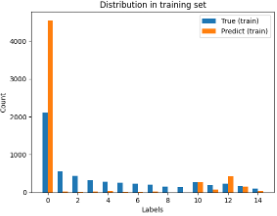![1.png](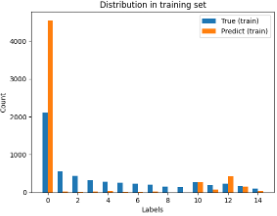![1.png](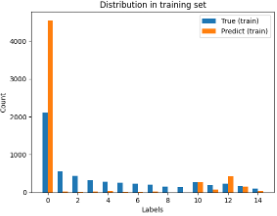![2.png](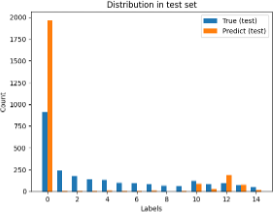![1.png](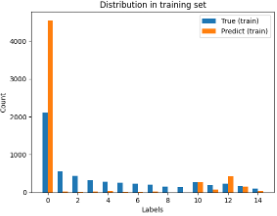![1.png](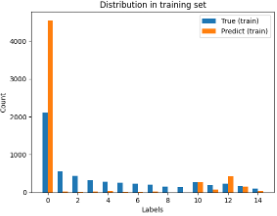![1.png](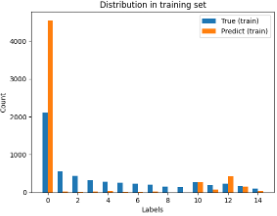![1.jpg](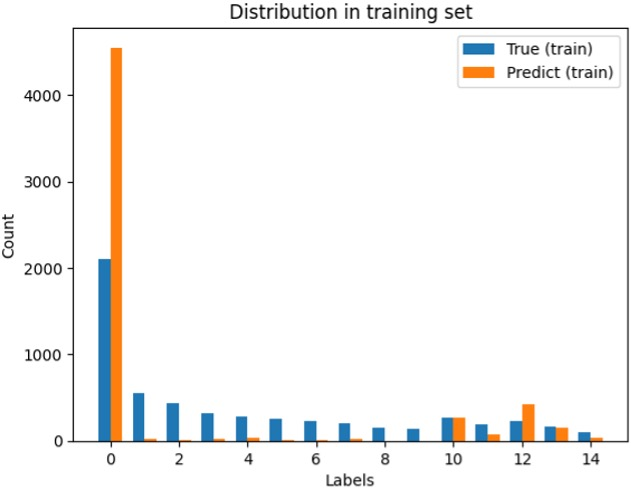![1.png](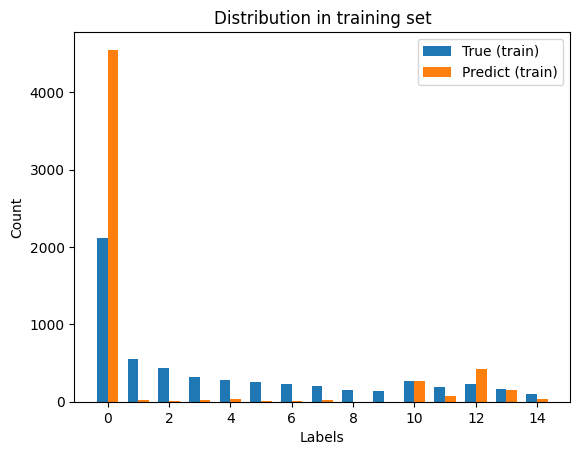![2.png](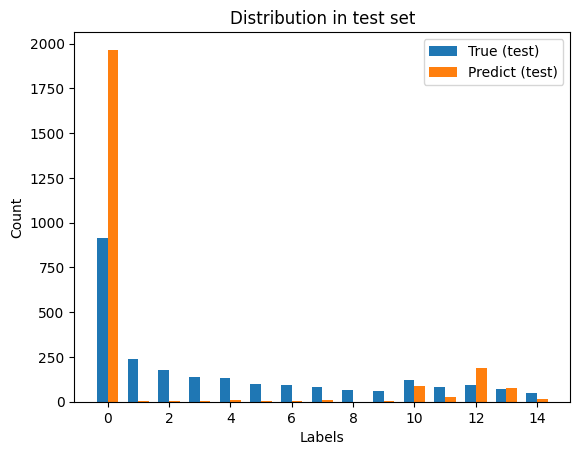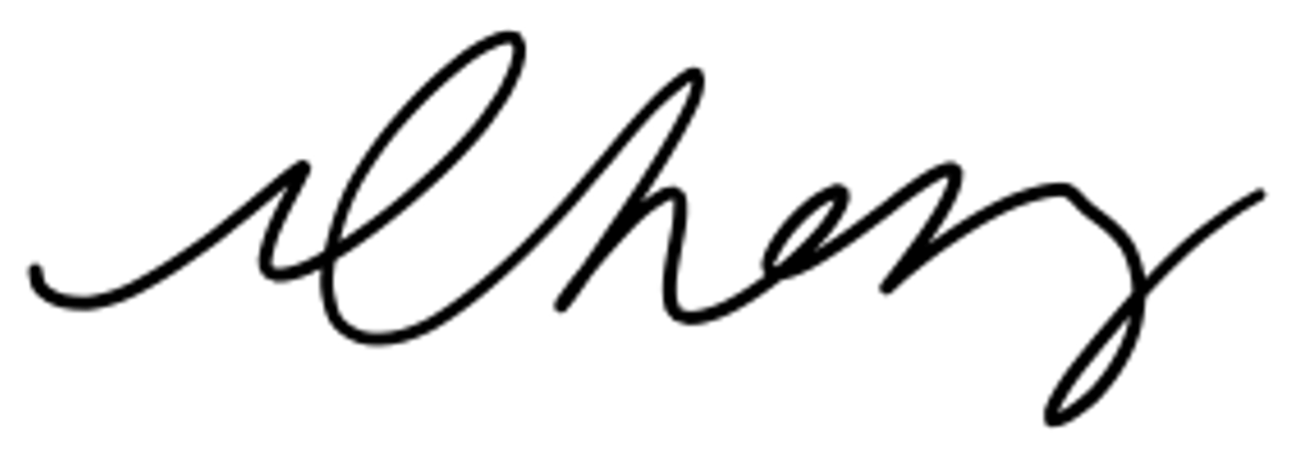))))))))))

Q5: there's only one category, can drop this feature

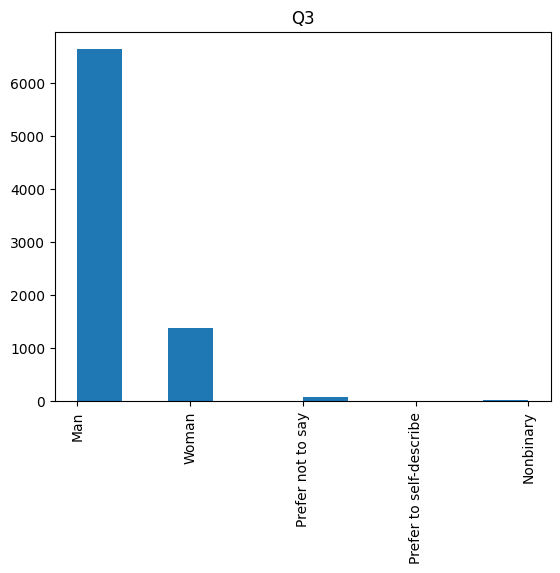

From this plot, we can see the vast majority of people consist of man and woman, we can select a subset of data containing only man group and woman group.
In this way, we simply use one-hot encoding/label encoding to encode this question feature.


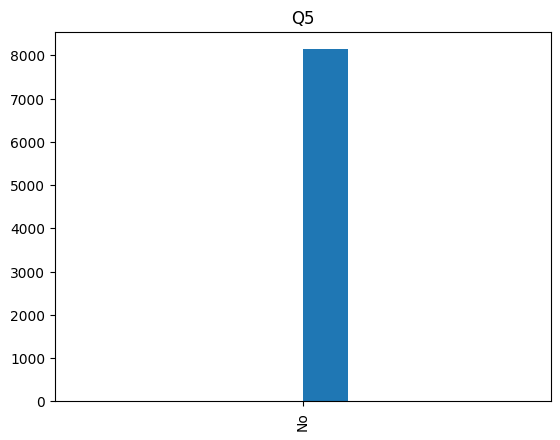

From this plot, we can see there is only one category in this feature, we can drop this feature as it does not contribute to the prediction in our later phase.


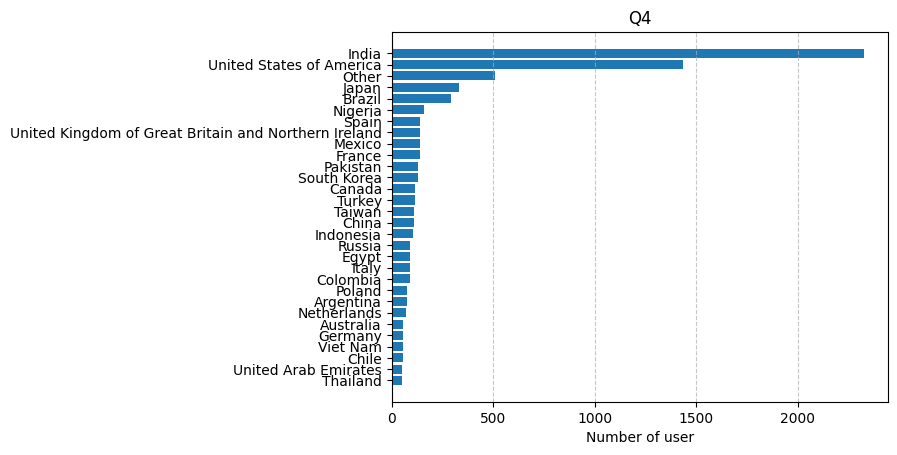

Poeple from India: 2328 ; People from US: 1434 ; People from places other than India and US: 4374


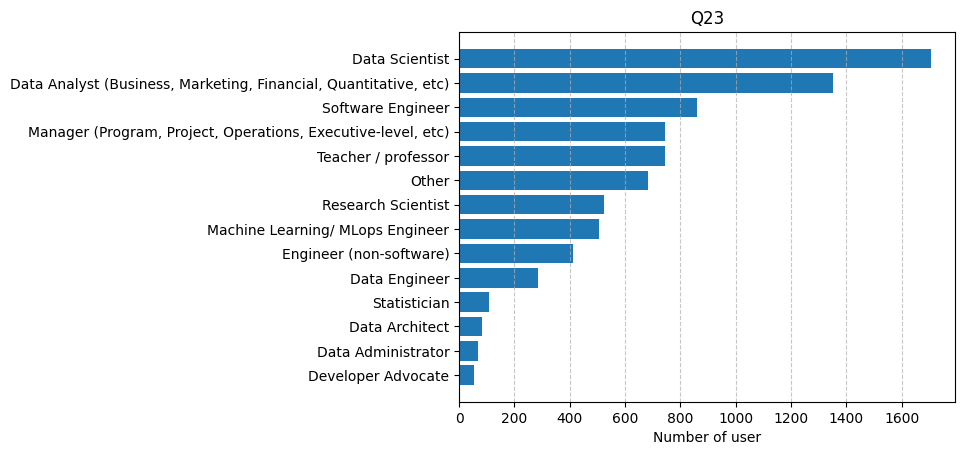

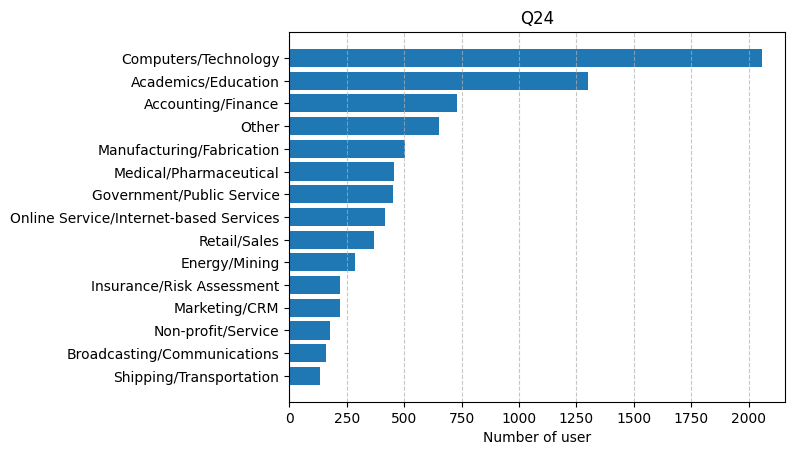

In [18]:
plt.hist(data['Q3']) # visualize Q3 feature distribution
plt.xticks(rotation='vertical')
plt.title('Q3')
plt.show()
print('From this plot, we can see the vast majority of people consist of man and woman, we can select a subset of data containing only man group and woman group.\n\
In this way, we simply use one-hot encoding/label encoding to encode this question feature.')

plt.hist(data['Q5']) # visualize Q5 feature distribution
plt.xticks(rotation='vertical')
plt.title('Q5')
plt.show()
print('From this plot, we can see there is only one category in this feature, we can drop this feature as it does not contribute to the prediction in our later phase.')

def plot_barh_n(data,Q_num,is_multi=True): # copied from previous assignment
  if is_multi:
    Q12_col = [col for col in data if col.startswith(Q_num)] # find all columns related to Q
  else:
    Q12_col = [Q_num]
  unique_languages = []
  for col in Q12_col:
    unique_languages.extend(data[col].unique())
  unique_values = list(set(unique_languages)) # find unique value
  unique_values = [x for x in unique_values if x == x] # drop nan

  language_counts = {}
  for col in Q12_col:
    for value in unique_values:
      count = (data[col] == value).sum()  # number of times of each unique value shows in each column
      if value in language_counts:
        language_counts[value] += count # add the total counts to the corresponding category
      else:
        language_counts[value] = count

  language_counts_sort = sorted(language_counts.items(), key=lambda x:x[1], reverse=False) # sort the number of users per each value
  bar_name = [item[0] for item in language_counts_sort] # collect bar names
  bar_value = [item[1] for item in language_counts_sort] # collect the corresponding value

  n = 30 # display the top n labels
  plt.barh(range(n), bar_value[-n:]) # horizontal bar plot
  plt.yticks(range(n), bar_name[-n:])
  plt.title(Q_num)
  plt.xlabel('Number of user')
  plt.grid(axis='x', linestyle='--', alpha=0.7)
  plt.show()

plot_barh_n(data,'Q4',False) # plot top 30 ranking countries by number of people
Q4_unique = get_unique(data,['Q4'],'')
Q4_counts = get_frequency(data,Q4_unique,['Q4'])
other_counts = sum(v for k, v in Q4_counts.items() if (k != 'India' and k != 'United States of America'))
print('Poeple from India:',Q4_counts['India'],';','People from US:',Q4_counts['United States of America'],';','People from places other than India and US:',other_counts)

plot_barh(data,'Q23')
plot_barh(data,'Q24')

In [19]:
#drop these features: ['Duration (in seconds)','Q5','Q7','Q21','Q29']

data = data.drop(columns=['Q29']) # drop Q29 feature
data = remove_feature(data,['Duration (in seconds)','Q5','Q7','Q21']) # drop other features

#select a subset of data containing man and woman group
data = data.loc[data['Q3'].isin(['Man','Woman'])]

#perform one-hot encoding for these features: ['Q6','Q12','Q13','Q14','Q15','Q17','Q18','Q28','Q31','Q35','Q36','Q37','Q38','Q39','Q40','Q41','Q42','Q44']
def one_hot_encoding(df,Q_num,fill):
  Q_col = get_col(df,Q_num)
  unique_vals = get_unique(df,Q_col,fill) # get unique values except for the filling variable 'Unknown'
  val_counts = get_frequency(df,unique_vals,Q_col)

  _,val_labels = freq_oneh_encode(val_counts)

  for col in Q_col:
    df[col] = df[col].map(val_labels).fillna(0).astype(int)
  return df

one_hot_list = ['Q6','Q12','Q13','Q14','Q15','Q17','Q18','Q28','Q31','Q35','Q36','Q37','Q38','Q39','Q40','Q41','Q42','Q44']

for el in one_hot_list:
  data = one_hot_encoding(data,el,'Unknown')

In [20]:
data.iloc[0:4,:] # show 4 rows of the dataset

,Q2,Q3,Q4,Q6_1,Q6_2,Q6_3,Q6_4,Q6_5,Q6_6,Q6_7,Q6_8,Q6_9,Q6_10,Q6_11,Q6_12,Q8,Q9,Q11,Q12_1,Q12_2,Q12_3,Q12_4,Q12_5,Q12_6,Q12_7,Q12_8,Q12_9,Q12_10,Q12_11,Q12_12,Q12_13,Q12_14,Q12_15,Q13_1,Q13_2,Q13_3,Q13_4,Q13_5,Q13_6,Q13_7,Q13_8,Q13_9,Q13_10,Q13_11,Q13_12,Q13_13,Q13_14,Q14_1,Q14_2,Q14_3,Q14_4,Q14_5,Q14_6,Q14_7,Q14_8,Q14_9,Q14_10,Q14_11,Q14_12,Q14_13,Q14_14,Q14_15,Q14_16,Q15_1,Q15_2,Q15_3,Q15_4,Q15_5,Q15_6,Q15_7,Q15_8,Q15_9,Q15_10,Q15_11,Q15_12,Q15_13,Q15_14,Q15_15,Q16,Q17_1,Q17_2,Q17_3,Q17_4,Q17_5,Q17_6,Q17_7,Q17_8,Q17_9,Q17_10,Q17_11,Q17_12,Q17_13,Q17_14,Q17_15,Q18_1,Q18_2,Q18_3,Q18_4,Q18_5,Q18_6,Q18_7,Q18_8,Q18_9,Q18_10,Q18_11,Q18_12,Q18_13,Q18_14,Q23,Q24,Q25,Q26,Q27,Q28_1,Q28_2,Q28_3,Q28_4,Q28_5,Q28_6,Q28_7,Q28_8,Q30,Q31_1,Q31_2,Q31_3,Q31_4,Q31_5,Q31_6,Q31_7,Q31_8,Q31_9,Q31_10,Q31_11,Q31_12,Q35_1,Q35_2,Q35_3,Q35_4,Q35_5,Q35_6,Q35_7,Q35_8,Q35_9,Q35_10,Q35_11,Q35_12,Q35_13,Q35_14,Q35_15,Q35_16,Q36_1,Q36_2,Q36_3,Q36_4,Q36_5,Q36_6,Q36_7,Q36_8,Q36_9,Q36_10,Q36_11,Q36_12,Q36_13,Q36_14,Q36_15,Q37_1,Q37_2,Q37_3,Q37_4,Q37_5,Q37_6,Q37_7,Q37_8,Q37_9,Q37_10,Q37_11,Q37_12,Q37_13,Q38_1,Q38_2,Q38_3,Q38_4,Q38_5,Q38_6,Q38_7,Q38_8,Q39_1,Q39_2,Q39_3,Q39_4,Q39_5,Q39_6,Q39_7,Q39_8,Q39_9,Q39_10,Q39_11,Q39_12,Q40_1,Q40_2,Q40_3,Q40_4,Q40_5,Q40_6,Q40_7,Q40_8,Q40_9,Q40_10,Q40_11,Q40_12,Q40_13,Q40_14,Q40_15,Q41_1,Q41_2,Q41_3,Q41_4,Q41_5,Q41_6,Q41_7,Q41_8,Q41_9,Q42_1,Q42_2,Q42_3,Q42_4,Q42_5,Q42_6,Q42_7,Q42_8,Q42_9,Q43,Q44_1,Q44_2,Q44_3,Q44_4,Q44_5,Q44_6,Q44_7,Q44_8,Q44_9,Q44_10,Q44_11,Q44_12,Q29_Encoded,Q29_buckets
0,55-59,Man,France,1,0,1,0,0,0,1,0,0,0,0,1,Some college/university study without earning ...,Unknown,10-20 years,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1-2 years,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,Data Scientist,Online Service/Internet-based Services,0-49 employees,2-Jan,"We recently started using ML methods (i.e., mo...",0,0,1,1,1,0,0,0,"$1000-$9,999",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,2-5 times,1,0,0,1,1,0,0,1,0,0,0,0,2.0,"20,000-29,999"
1,30-34,Man,Germany,1,1,0,0,0,1,1,0,0,0,0,0,BachelorEEs degree,Unknown,10-20 years,1,0,1,1,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,4-5 years,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,1,0,0,Software Engineer,Insurance/Risk Assessment,250-999 employees,20+,"We have well established ML methods (i.e., mod...",1,1,1,1,0,1,0,0,$0 ($USD),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Unknown,1,1,1,0,0,1,0,1,0,0,0,0,10.0,"100,000-124,999"
2,70+,Man,Australia,1,0,1,0,0,0,0,0,0,0,0,0,Doctoral degree,Yes,20+ years,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,5-10 years,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,Research Scientist,Government/Public Service,"1000-9,999 employees",20+,"We recently started using ML methods (i.e., mo...",0,0,1,0,0,0,0,0,$100-$999,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,Never,0,1,0,0,0,0,1,0,0,0,0,0,10.0,"100,000-124,999"
3,40-44,Man,United States of America,1,0,1,0,1,1,1,0,0,0,0,1,Doctoral degree,Yes,10-20 years,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,5-10 years,1,1,1,1,0,1,0,0,0,0,0,0,1,0,0,1,1,1,0,0,1,1,0,0,1,0,0,0,0,Developer Advocate,Computers/Technology,"1000-9,999 employees",20+,"We have well established ML me

In [21]:
#the following part is not relevant to part 2
################################################################################
data_backup2 = data.copy() # needs to encode Q2, Q3, Q8, Q9, Q11, Q16, Q23, Q24, Q25, Q26, Q27, Q30, Q43

#this dataset will be used to explore the impact of feature engineering on the performance of the ordinal logistic regression model
#for this backup dataset do the following encoding

#Q3 (label encoding/one-hot encoding)
data_backup2['Q3'] = data_backup2['Q3'].map({'Man': 1, 'Woman': 0})
#Q9 (label encoding, treat 'Unknown' as a new category)
data_backup2['Q9'] = data_backup2['Q9'].map({'Unknown': 0, 'No': 1, 'Yes': 2})

#Q2 (older with larger number)
data_backup2['Q2'] = data_backup2['Q2'].map({'70+':10, '18-21':0, '50-54':7, '45-49':6, '55-59':8, '60-69':9, '30-34':3, '40-44':5, '22-24':1, '35-39':4, '25-29':2})

#Q8 (higher education with larger number)
data_backup2['Q8'] = data_backup2['Q8'].map({'Some college/university study without earning a bachelor\x81E\x80\x81Es degree':2,
                             'Master\x81E\x80\x81Es degree':4,
                             'Professional doctorate':5,
                             'I prefer not to answer':0,
                             'Bachelor\x81E\x80\x81Es degree':3,
                             'Doctoral degree':6,
                             'No formal education past high school':1})
#Q11
data_backup2['Q11'] = data_backup2['Q11'].map({'3-5 years':3,
                               '1-3 years':2,
                               'I have never written code':0,
                               '10-20 years':5,
                               '5-10 years':4,
                               '20+ years':6,
                               '< 1 years':1})

#Q16
data_backup2['Q16'] = data_backup2['Q16'].map({'2-3 years':4,
                               'I do not use machine learning methods':1,
                               'Under 1 year':2,
                               '10-20 years':8,
                               '5-10 years':7,
                               '1-2 years':3,
                               '3-4 years':5,
                               'Unknown':0,
                               '4-5 years':6})

#Q25
data_backup2['Q25'] = data_backup2['Q25'].map({'50-249 employees':1,
                               '10,000 or more employees':4,
                               '250-999 employees':2,
                               '0-49 employees':0,
                               '1000-9,999 employees':3})

#Q26
data_backup2['Q26'] = data_backup2['Q26'].map({'20+':6,
                               '2-Jan':1,
                               '15-19':5,
                               '4-Mar':2,
                               '9-May':3,
                               '14-Oct':4,
                               '0':0})

#Q27
data_backup2['Q27'] = data_backup2['Q27'].map({'We recently started using ML methods (i.e., models in production for less than 2 years)':4,
                               'We are exploring ML methods (and may one day put a model into production)':3,
                               'We use ML methods for generating insights (but do not put working models into production)':2,
                               'No (we do not use ML methods)':1,
                               'We have well established ML methods (i.e., models in production for more than 2 years)':5,
                               'I do not know':0})

#Q30
data_backup2['Q30'] = data_backup2['Q30'].map({'$10,000-$99,999':5,
                               'Unknown':0,
                               '$1000-$9,999':4,
                               '$0 ($USD)':1,
                               '$100,000 or more ($USD)':6,
                               '$1-$99':2,
                               '$100-$999':3})

#Q43
data_backup2['Q43'] = data_backup2['Q43'].map({'6-25 times':4, 'Unknown':0, '2-5 times':3, 'More than 25 times':5, 'Never':1, 'Once':2})

#split in training and test set
X_y_train_backup2, X_y_test_backup2 = train_test_split(data_backup2, test_size=0.30, random_state=0) # 70% training set 30% test set

#Q23 target encoding by median
medians = X_y_train_backup2.groupby('Q23')['Q29_Encoded'].median().round().astype(int) # get median encoded salary for each job title in the training set
X_y_train_backup2['Q23'] = X_y_train_backup2['Q23'].map(medians) # map the medians to training set
X_y_test_backup2['Q23'] = X_y_test_backup2['Q23'].map(medians) # map the medians to test set

#Q24 target encoding by median
medians = X_y_train_backup2.groupby('Q24')['Q29_Encoded'].median().round().astype(int) # get median encoded salary for each industry in the training set
X_y_train_backup2['Q24'] = X_y_train_backup2['Q24'].map(medians) # map the medians to training set
X_y_test_backup2['Q24'] = X_y_test_backup2['Q24'].map(medians) # map the medians to test set
################################################################################

In [22]:
# #perform feature aggregation (to calculate the total selected options) for the one-hot encoded features above
# one_hot_list = ['Q6','Q12','Q13','Q14','Q15','Q17','Q18','Q28','Q31','Q35','Q36','Q37','Q38','Q39','Q40','Q41','Q42','Q44']
# data_add = pd.DataFrame()
# for el in one_hot_list:
#   Q_col = get_col(data, el)  # the columns to be summed
#   data_add[el] = data[Q_col].sum(axis=1)  # create a new column for the sum
#   data = data.drop(Q_col, axis=1)  # drop the original columns

In [23]:
# data_add.iloc[0:4,:] # show 4 rows of the dataset

In [24]:
# data = pd.concat([data_add,data], axis=1)
# data.shape

In [25]:
data.iloc[0:4,:] # show 4 rows of the dataset

,Q2,Q3,Q4,Q6_1,Q6_2,Q6_3,Q6_4,Q6_5,Q6_6,Q6_7,Q6_8,Q6_9,Q6_10,Q6_11,Q6_12,Q8,Q9,Q11,Q12_1,Q12_2,Q12_3,Q12_4,Q12_5,Q12_6,Q12_7,Q12_8,Q12_9,Q12_10,Q12_11,Q12_12,Q12_13,Q12_14,Q12_15,Q13_1,Q13_2,Q13_3,Q13_4,Q13_5,Q13_6,Q13_7,Q13_8,Q13_9,Q13_10,Q13_11,Q13_12,Q13_13,Q13_14,Q14_1,Q14_2,Q14_3,Q14_4,Q14_5,Q14_6,Q14_7,Q14_8,Q14_9,Q14_10,Q14_11,Q14_12,Q14_13,Q14_14,Q14_15,Q14_16,Q15_1,Q15_2,Q15_3,Q15_4,Q15_5,Q15_6,Q15_7,Q15_8,Q15_9,Q15_10,Q15_11,Q15_12,Q15_13,Q15_14,Q15_15,Q16,Q17_1,Q17_2,Q17_3,Q17_4,Q17_5,Q17_6,Q17_7,Q17_8,Q17_9,Q17_10,Q17_11,Q17_12,Q17_13,Q17_14,Q17_15,Q18_1,Q18_2,Q18_3,Q18_4,Q18_5,Q18_6,Q18_7,Q18_8,Q18_9,Q18_10,Q18_11,Q18_12,Q18_13,Q18_14,Q23,Q24,Q25,Q26,Q27,Q28_1,Q28_2,Q28_3,Q28_4,Q28_5,Q28_6,Q28_7,Q28_8,Q30,Q31_1,Q31_2,Q31_3,Q31_4,Q31_5,Q31_6,Q31_7,Q31_8,Q31_9,Q31_10,Q31_11,Q31_12,Q35_1,Q35_2,Q35_3,Q35_4,Q35_5,Q35_6,Q35_7,Q35_8,Q35_9,Q35_10,Q35_11,Q35_12,Q35_13,Q35_14,Q35_15,Q35_16,Q36_1,Q36_2,Q36_3,Q36_4,Q36_5,Q36_6,Q36_7,Q36_8,Q36_9,Q36_10,Q36_11,Q36_12,Q36_13,Q36_14,Q36_15,Q37_1,Q37_2,Q37_3,Q37_4,Q37_5,Q37_6,Q37_7,Q37_8,Q37_9,Q37_10,Q37_11,Q37_12,Q37_13,Q38_1,Q38_2,Q38_3,Q38_4,Q38_5,Q38_6,Q38_7,Q38_8,Q39_1,Q39_2,Q39_3,Q39_4,Q39_5,Q39_6,Q39_7,Q39_8,Q39_9,Q39_10,Q39_11,Q39_12,Q40_1,Q40_2,Q40_3,Q40_4,Q40_5,Q40_6,Q40_7,Q40_8,Q40_9,Q40_10,Q40_11,Q40_12,Q40_13,Q40_14,Q40_15,Q41_1,Q41_2,Q41_3,Q41_4,Q41_5,Q41_6,Q41_7,Q41_8,Q41_9,Q42_1,Q42_2,Q42_3,Q42_4,Q42_5,Q42_6,Q42_7,Q42_8,Q42_9,Q43,Q44_1,Q44_2,Q44_3,Q44_4,Q44_5,Q44_6,Q44_7,Q44_8,Q44_9,Q44_10,Q44_11,Q44_12,Q29_Encoded,Q29_buckets
0,55-59,Man,France,1,0,1,0,0,0,1,0,0,0,0,1,Some college/university study without earning ...,Unknown,10-20 years,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1-2 years,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,Data Scientist,Online Service/Internet-based Services,0-49 employees,2-Jan,"We recently started using ML methods (i.e., mo...",0,0,1,1,1,0,0,0,"$1000-$9,999",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,2-5 times,1,0,0,1,1,0,0,1,0,0,0,0,2.0,"20,000-29,999"
1,30-34,Man,Germany,1,1,0,0,0,1,1,0,0,0,0,0,BachelorEEs degree,Unknown,10-20 years,1,0,1,1,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,4-5 years,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,1,0,0,Software Engineer,Insurance/Risk Assessment,250-999 employees,20+,"We have well established ML methods (i.e., mod...",1,1,1,1,0,1,0,0,$0 ($USD),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Unknown,1,1,1,0,0,1,0,1,0,0,0,0,10.0,"100,000-124,999"
2,70+,Man,Australia,1,0,1,0,0,0,0,0,0,0,0,0,Doctoral degree,Yes,20+ years,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,5-10 years,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,Research Scientist,Government/Public Service,"1000-9,999 employees",20+,"We recently started using ML methods (i.e., mo...",0,0,1,0,0,0,0,0,$100-$999,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,Never,0,1,0,0,0,0,1,0,0,0,0,0,10.0,"100,000-124,999"
3,40-44,Man,United States of America,1,0,1,0,1,1,1,0,0,0,0,1,Doctoral degree,Yes,10-20 years,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,5-10 years,1,1,1,1,0,1,0,0,0,0,0,0,1,0,0,1,1,1,0,0,1,1,0,0,1,0,0,0,0,Developer Advocate,Computers/Technology,"1000-9,999 employees",20+,"We have well established ML me

Q3 categories are:
['Man', 'Woman']
Q9 categories are:
['Unknown', 'No', 'Yes']


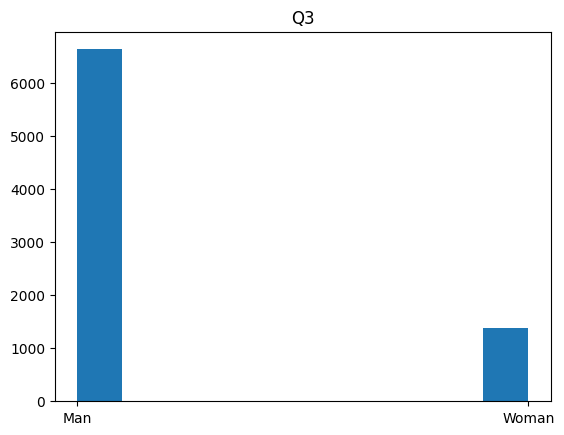

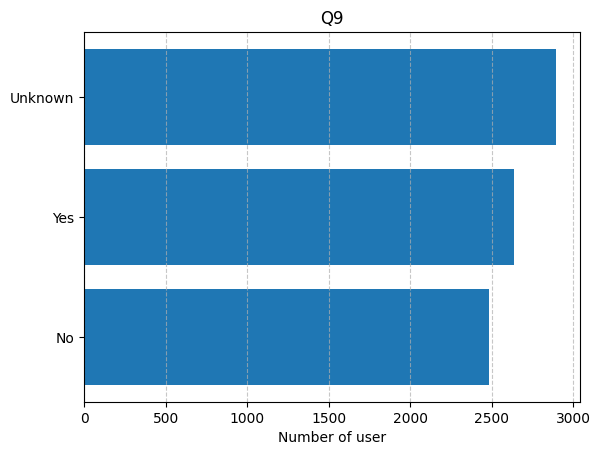

In [26]:
label_encode_list = ['Q3','Q9']
for el in label_encode_list:
  Q_entires = get_unique(data,[el],'')
  print(el+' categories are:')
  print(Q_entires)

plt.hist(data['Q3']) # visualize Q3 feature distribution
plt.title('Q3')
plt.show()
plot_barh(data,'Q9') # visualize Q9 feature distribution

In [27]:
#perform label encoding for these features: ['Q3','Q9']

#Q3 (label encoding/one-hot encoding)
data['Q3'] = data['Q3'].map({'Man': 1, 'Woman': 0})
#Q9 (label encoding, treat 'Unknown' as a new category)
data['Q9'] = data['Q9'].map({'Unknown': 0, 'No': 1, 'Yes': 2})

In [28]:
data.iloc[0:4,:] # show 4 rows of the dataset

,Q2,Q3,Q4,Q6_1,Q6_2,Q6_3,Q6_4,Q6_5,Q6_6,Q6_7,Q6_8,Q6_9,Q6_10,Q6_11,Q6_12,Q8,Q9,Q11,Q12_1,Q12_2,Q12_3,Q12_4,Q12_5,Q12_6,Q12_7,Q12_8,Q12_9,Q12_10,Q12_11,Q12_12,Q12_13,Q12_14,Q12_15,Q13_1,Q13_2,Q13_3,Q13_4,Q13_5,Q13_6,Q13_7,Q13_8,Q13_9,Q13_10,Q13_11,Q13_12,Q13_13,Q13_14,Q14_1,Q14_2,Q14_3,Q14_4,Q14_5,Q14_6,Q14_7,Q14_8,Q14_9,Q14_10,Q14_11,Q14_12,Q14_13,Q14_14,Q14_15,Q14_16,Q15_1,Q15_2,Q15_3,Q15_4,Q15_5,Q15_6,Q15_7,Q15_8,Q15_9,Q15_10,Q15_11,Q15_12,Q15_13,Q15_14,Q15_15,Q16,Q17_1,Q17_2,Q17_3,Q17_4,Q17_5,Q17_6,Q17_7,Q17_8,Q17_9,Q17_10,Q17_11,Q17_12,Q17_13,Q17_14,Q17_15,Q18_1,Q18_2,Q18_3,Q18_4,Q18_5,Q18_6,Q18_7,Q18_8,Q18_9,Q18_10,Q18_11,Q18_12,Q18_13,Q18_14,Q23,Q24,Q25,Q26,Q27,Q28_1,Q28_2,Q28_3,Q28_4,Q28_5,Q28_6,Q28_7,Q28_8,Q30,Q31_1,Q31_2,Q31_3,Q31_4,Q31_5,Q31_6,Q31_7,Q31_8,Q31_9,Q31_10,Q31_11,Q31_12,Q35_1,Q35_2,Q35_3,Q35_4,Q35_5,Q35_6,Q35_7,Q35_8,Q35_9,Q35_10,Q35_11,Q35_12,Q35_13,Q35_14,Q35_15,Q35_16,Q36_1,Q36_2,Q36_3,Q36_4,Q36_5,Q36_6,Q36_7,Q36_8,Q36_9,Q36_10,Q36_11,Q36_12,Q36_13,Q36_14,Q36_15,Q37_1,Q37_2,Q37_3,Q37_4,Q37_5,Q37_6,Q37_7,Q37_8,Q37_9,Q37_10,Q37_11,Q37_12,Q37_13,Q38_1,Q38_2,Q38_3,Q38_4,Q38_5,Q38_6,Q38_7,Q38_8,Q39_1,Q39_2,Q39_3,Q39_4,Q39_5,Q39_6,Q39_7,Q39_8,Q39_9,Q39_10,Q39_11,Q39_12,Q40_1,Q40_2,Q40_3,Q40_4,Q40_5,Q40_6,Q40_7,Q40_8,Q40_9,Q40_10,Q40_11,Q40_12,Q40_13,Q40_14,Q40_15,Q41_1,Q41_2,Q41_3,Q41_4,Q41_5,Q41_6,Q41_7,Q41_8,Q41_9,Q42_1,Q42_2,Q42_3,Q42_4,Q42_5,Q42_6,Q42_7,Q42_8,Q42_9,Q43,Q44_1,Q44_2,Q44_3,Q44_4,Q44_5,Q44_6,Q44_7,Q44_8,Q44_9,Q44_10,Q44_11,Q44_12,Q29_Encoded,Q29_buckets
0,55-59,1,France,1,0,1,0,0,0,1,0,0,0,0,1,Some college/university study without earning ...,0,10-20 years,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1-2 years,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,Data Scientist,Online Service/Internet-based Services,0-49 employees,2-Jan,"We recently started using ML methods (i.e., mo...",0,0,1,1,1,0,0,0,"$1000-$9,999",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,2-5 times,1,0,0,1,1,0,0,1,0,0,0,0,2.0,"20,000-29,999"
1,30-34,1,Germany,1,1,0,0,0,1,1,0,0,0,0,0,BachelorEEs degree,0,10-20 years,1,0,1,1,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,4-5 years,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,1,0,0,Software Engineer,Insurance/Risk Assessment,250-999 employees,20+,"We have well established ML methods (i.e., mod...",1,1,1,1,0,1,0,0,$0 ($USD),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Unknown,1,1,1,0,0,1,0,1,0,0,0,0,10.0,"100,000-124,999"
2,70+,1,Australia,1,0,1,0,0,0,0,0,0,0,0,0,Doctoral degree,2,20+ years,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,5-10 years,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,Research Scientist,Government/Public Service,"1000-9,999 employees",20+,"We recently started using ML methods (i.e., mo...",0,0,1,0,0,0,0,0,$100-$999,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,Never,0,1,0,0,0,0,1,0,0,0,0,0,10.0,"100,000-124,999"
3,40-44,1,United States of America,1,0,1,0,1,1,1,0,0,0,0,1,Doctoral degree,2,10-20 years,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,5-10 years,1,1,1,1,0,1,0,0,0,0,0,0,1,0,0,1,1,1,0,0,1,1,0,0,1,0,0,0,0,Developer Advocate,Computers/Technology,"1000-9,999 employees",20+,"We have well established ML methods (i.e., mod...",0,0

In [29]:
label_encode_list = ['Q2','Q8','Q11','Q16','Q25','Q26','Q27','Q30','Q43']
for el in label_encode_list:
  Q_entires = get_unique(data,[el],'')
  print(el+' categories are:')
  print(Q_entires)

print('In Q26, the categorical entries are not correctly interpreted, here, I will do the translation:\n\
2-Jan means 1-2, 4-Mar means 3-4, 9-May means 5-9, 14-Oct means 10-14')
print('In Q8, the prime sign is a weird charactor in the original CSV file')

Q2 categories are:
['55-59', '45-49', '50-54', '35-39', '70+', '25-29', '22-24', '40-44', '30-34', '60-69', '18-21']
Q8 categories are:
['Some college/university study without earning a bachelor\x81E\x80\x81Es degree', 'I prefer not to answer', 'No formal education past high school', 'Professional doctorate', 'Doctoral degree', 'Master\x81E\x80\x81Es degree', 'Bachelor\x81E\x80\x81Es degree']
Q11 categories are:
['10-20 years', '3-5 years', '< 1 years', 'I have never written code', '20+ years', '1-3 years', '5-10 years']
Q16 categories are:
['I do not use machine learning methods', '4-5 years', '10-20 years', '1-2 years', '2-3 years', '3-4 years', 'Unknown', '5-10 years', 'Under 1 year']
Q25 categories are:
['0-49 employees', '10,000 or more employees', '50-249 employees', '250-999 employees', '1000-9,999 employees']
Q26 categories are:
['4-Mar', '9-May', '2-Jan', '20+', '15-19', '14-Oct', '0']
Q27 categories are:
['We use ML methods for generating insights (but do not put working mode

The ordinal ranking hierarchy:

'Unkown' < answers like 'Prefer not to answer' < answers like 'None', 'Never', 'No' < the remaining ordinal answers...

In [30]:
#perform ordinal encoding for these features: ['Q2','Q8','Q11','Q16','Q25','Q26','Q27','Q30','Q43']

#Q2 (older with larger number)
data['Q2'] = data['Q2'].map({'70+':10, '18-21':0, '50-54':7, '45-49':6, '55-59':8, '60-69':9, '30-34':3, '40-44':5, '22-24':1, '35-39':4, '25-29':2})

#Q8 (higher education with larger number)
data['Q8'] = data['Q8'].map({'Some college/university study without earning a bachelor\x81E\x80\x81Es degree':2,
                             'Master\x81E\x80\x81Es degree':4,
                             'Professional doctorate':5,
                             'I prefer not to answer':0,
                             'Bachelor\x81E\x80\x81Es degree':3,
                             'Doctoral degree':6,
                             'No formal education past high school':1})
#Q11
data['Q11'] = data['Q11'].map({'3-5 years':3,
                               '1-3 years':2,
                               'I have never written code':0,
                               '10-20 years':5,
                               '5-10 years':4,
                               '20+ years':6,
                               '< 1 years':1})

#Q16
data['Q16'] = data['Q16'].map({'2-3 years':4,
                               'I do not use machine learning methods':1,
                               'Under 1 year':2,
                               '10-20 years':8,
                               '5-10 years':7,
                               '1-2 years':3,
                               '3-4 years':5,
                               'Unknown':0,
                               '4-5 years':6})

#Q25
data['Q25'] = data['Q25'].map({'50-249 employees':1,
                               '10,000 or more employees':4,
                               '250-999 employees':2,
                               '0-49 employees':0,
                               '1000-9,999 employees':3})

#Q26
data['Q26'] = data['Q26'].map({'20+':6,
                               '2-Jan':1,
                               '15-19':5,
                               '4-Mar':2,
                               '9-May':3,
                               '14-Oct':4,
                               '0':0})

#Q27
data['Q27'] = data['Q27'].map({'We recently started using ML methods (i.e., models in production for less than 2 years)':4,
                               'We are exploring ML methods (and may one day put a model into production)':3,
                               'We use ML methods for generating insights (but do not put working models into production)':2,
                               'No (we do not use ML methods)':1,
                               'We have well established ML methods (i.e., models in production for more than 2 years)':5,
                               'I do not know':0})

#Q30
data['Q30'] = data['Q30'].map({'$10,000-$99,999':5,
                               'Unknown':0,
                               '$1000-$9,999':4,
                               '$0 ($USD)':1,
                               '$100,000 or more ($USD)':6,
                               '$1-$99':2,
                               '$100-$999':3})

#Q43
data['Q43'] = data['Q43'].map({'6-25 times':4, 'Unknown':0, '2-5 times':3, 'More than 25 times':5, 'Never':1, 'Once':2})


In [31]:
data.iloc[0:4,:] # show 4 rows of the dataset

,Q2,Q3,Q4,Q6_1,Q6_2,Q6_3,Q6_4,Q6_5,Q6_6,Q6_7,Q6_8,Q6_9,Q6_10,Q6_11,Q6_12,Q8,Q9,Q11,Q12_1,Q12_2,Q12_3,Q12_4,Q12_5,Q12_6,Q12_7,Q12_8,Q12_9,Q12_10,Q12_11,Q12_12,Q12_13,Q12_14,Q12_15,Q13_1,Q13_2,Q13_3,Q13_4,Q13_5,Q13_6,Q13_7,Q13_8,Q13_9,Q13_10,Q13_11,Q13_12,Q13_13,Q13_14,Q14_1,Q14_2,Q14_3,Q14_4,Q14_5,Q14_6,Q14_7,Q14_8,Q14_9,Q14_10,Q14_11,Q14_12,Q14_13,Q14_14,Q14_15,Q14_16,Q15_1,Q15_2,Q15_3,Q15_4,Q15_5,Q15_6,Q15_7,Q15_8,Q15_9,Q15_10,Q15_11,Q15_12,Q15_13,Q15_14,Q15_15,Q16,Q17_1,Q17_2,Q17_3,Q17_4,Q17_5,Q17_6,Q17_7,Q17_8,Q17_9,Q17_10,Q17_11,Q17_12,Q17_13,Q17_14,Q17_15,Q18_1,Q18_2,Q18_3,Q18_4,Q18_5,Q18_6,Q18_7,Q18_8,Q18_9,Q18_10,Q18_11,Q18_12,Q18_13,Q18_14,Q23,Q24,Q25,Q26,Q27,Q28_1,Q28_2,Q28_3,Q28_4,Q28_5,Q28_6,Q28_7,Q28_8,Q30,Q31_1,Q31_2,Q31_3,Q31_4,Q31_5,Q31_6,Q31_7,Q31_8,Q31_9,Q31_10,Q31_11,Q31_12,Q35_1,Q35_2,Q35_3,Q35_4,Q35_5,Q35_6,Q35_7,Q35_8,Q35_9,Q35_10,Q35_11,Q35_12,Q35_13,Q35_14,Q35_15,Q35_16,Q36_1,Q36_2,Q36_3,Q36_4,Q36_5,Q36_6,Q36_7,Q36_8,Q36_9,Q36_10,Q36_11,Q36_12,Q36_13,Q36_14,Q36_15,Q37_1,Q37_2,Q37_3,Q37_4,Q37_5,Q37_6,Q37_7,Q37_8,Q37_9,Q37_10,Q37_11,Q37_12,Q37_13,Q38_1,Q38_2,Q38_3,Q38_4,Q38_5,Q38_6,Q38_7,Q38_8,Q39_1,Q39_2,Q39_3,Q39_4,Q39_5,Q39_6,Q39_7,Q39_8,Q39_9,Q39_10,Q39_11,Q39_12,Q40_1,Q40_2,Q40_3,Q40_4,Q40_5,Q40_6,Q40_7,Q40_8,Q40_9,Q40_10,Q40_11,Q40_12,Q40_13,Q40_14,Q40_15,Q41_1,Q41_2,Q41_3,Q41_4,Q41_5,Q41_6,Q41_7,Q41_8,Q41_9,Q42_1,Q42_2,Q42_3,Q42_4,Q42_5,Q42_6,Q42_7,Q42_8,Q42_9,Q43,Q44_1,Q44_2,Q44_3,Q44_4,Q44_5,Q44_6,Q44_7,Q44_8,Q44_9,Q44_10,Q44_11,Q44_12,Q29_Encoded,Q29_buckets
0,8,1,France,1,0,1,0,0,0,1,0,0,0,0,1,2,0,5,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,Data Scientist,Online Service/Internet-based Services,0,1,4,0,0,1,1,1,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,3,1,0,0,1,1,0,0,1,0,0,0,0,2.0,"20,000-29,999"
1,3,1,Germany,1,1,0,0,0,1,1,0,0,0,0,0,3,0,5,1,0,1,1,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,6,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,1,0,0,Software Engineer,Insurance/Risk Assessment,2,6,5,1,1,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,1,0,0,0,0,10.0,"100,000-124,999"
2,10,1,Australia,1,0,1,0,0,0,0,0,0,0,0,0,6,2,6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,Research Scientist,Government/Public Service,3,6,4,0,0,1,0,0,0,0,0,3,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,10.0,"100,000-124,999"
3,5,1,United States of America,1,0,1,0,1,1,1,0,0,0,0,1,6,2,5,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,7,1,1,1,1,0,1,0,0,0,0,0,0,1,0,0,1,1,1,0,0,1,1,0,0,1,0,0,0,0,Developer Advocate,Computers/Technology,3,6,5,0,0,1,0,0,0,0,1,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,3,1,1,0,0,0,0,1,1,0,0,0,0,13.0,"200,000-299,999"


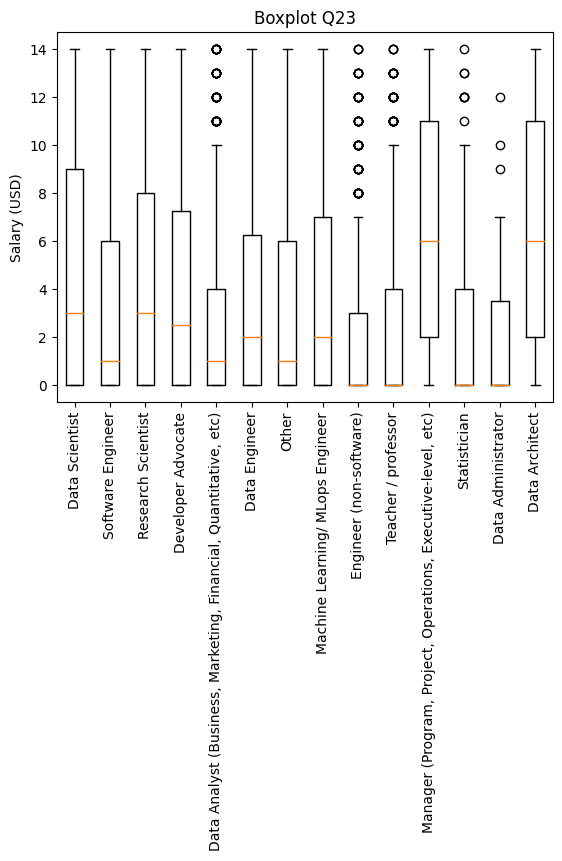

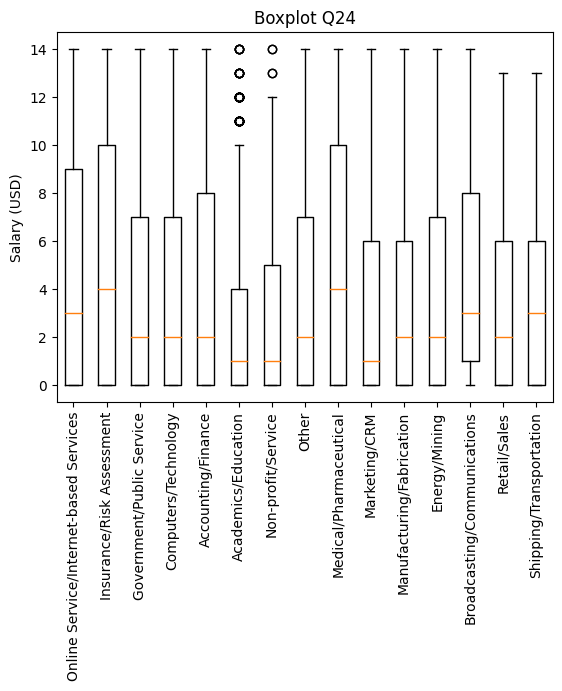

From the boxplot of job title/industry vs. encoded salary, most of them exhibit positively skewed distribution, therefore, median is a measurement of central tendency


In [32]:
unique_val = data['Q23'].unique()
boxplot_data = []  # list to store data for boxplot
boxplot_labels = []  # list to store labels for boxplot

for el in unique_val:
  val_salary = data[data['Q23'] == el]['Q29_Encoded']
  boxplot_data.append(val_salary)
  boxplot_labels.append(el)

plt.boxplot(boxplot_data, labels=boxplot_labels)  # box plot
plt.ylabel('Salary (USD)')
plt.xticks(rotation='vertical')
plt.title('Boxplot Q23')
plt.show()

unique_val = data['Q24'].unique()
boxplot_data = []  # list to store data for boxplot
boxplot_labels = []  # list to store labels for boxplot

for el in unique_val:
  val_salary = data[data['Q24'] == el]['Q29_Encoded']
  boxplot_data.append(val_salary)
  boxplot_labels.append(el)

plt.boxplot(boxplot_data, labels=boxplot_labels)  # box plot
plt.ylabel('Salary (USD)')
plt.xticks(rotation='vertical')
plt.title('Boxplot Q24')
plt.show()

print('From the boxplot of job title/industry vs. encoded salary, most of them exhibit positively skewed distribution, therefore, median is a measurement of central tendency')

In [33]:
#perform target encoding for these features: ['Q23','Q24','Q4']

#split in training and test set
X_y_train, X_y_test = train_test_split(data, test_size=0.30, random_state=0) # 70% training set 30% test set

#Q23 target encoding by median
medians = X_y_train.groupby('Q23')['Q29_Encoded'].median().round().astype(int) # get median encoded salary for each job title in the training set
X_y_train['Q23'] = X_y_train['Q23'].map(medians) # map the medians to training set
X_y_test['Q23'] = X_y_test['Q23'].map(medians) # map the medians to test set

#Q24 target encoding by median
medians = X_y_train.groupby('Q24')['Q29_Encoded'].median().round().astype(int) # get median encoded salary for each industry in the training set
X_y_train['Q24'] = X_y_train['Q24'].map(medians) # map the medians to training set
X_y_test['Q24'] = X_y_test['Q24'].map(medians) # map the medians to test set

#Q24 target encoding by median
medians = X_y_train.groupby('Q4')['Q29_Encoded'].median().round().astype(int) # get median encoded salary for each industry in the training set
X_y_train['Q4'] = X_y_train['Q4'].map(medians) # map the medians to training set
X_y_test['Q4'] = X_y_test['Q4'].map(medians) # map the medians to test set

In [34]:
X_y_train.iloc[0:4,:] # show 4 rows of the dataset
X_y_train_backup = X_y_train.copy()

In [35]:
# def cramers_v(x, y):
#   confusion_matrix = pd.crosstab(x,y)
#   chi2 = stats.chi2_contingency(confusion_matrix)[0]
#   n = confusion_matrix.sum().sum()
#   phi2 = chi2/n
#   r,k = confusion_matrix.shape
#   phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
#   rcorr = r-((r-1)**2)/(n-1)
#   kcorr = k-((k-1)**2)/(n-1)
#   return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

X_train = X_y_train.iloc[:,:-2].values
y_train = X_y_train.iloc[:,-2].values

cat_cols = X_y_train.columns[:-2]
# cramer_v_matrix = pd.DataFrame(index=cat_cols, columns=cat_cols, dtype=float)
# for col1 in cat_cols:
#   for col2 in cat_cols:
#     cramer_value = cramers_v(X_y_train[col1], X_y_train[col2])
#     cramer_v_matrix.loc[col1, col2] = cramer_value
# # print(cramer_v_matrix)
# plt.figure(figsize=(20, 16))
# sns.heatmap(cramer_v_matrix, annot=True, fmt=".2f", cmap="coolwarm") # Create a heatmap using seaborn's heatmap function
# plt.xlabel("Categorical Features")
# plt.ylabel("Categorical Features")
# plt.title("Cramer's V Heatmap")
# plt.show()

About Cramer's V:
Cramer's V is based on a nominal variation of Pearson's Chi-Square Test. Its output is in the range of [0,1], which is similar to the correlation, where 0 means no association and 1 means the highest association. However, unlike correlation, there are no negative values, which means they either have association or don't have association.

From the heatmap above, we can see there're some feature groups that have correlation larger than or equal to 0.7:

Q8 and Q9

Q42, Q39 and Q40

Q38 and Q37

Feature: Q4, Importance: 0.092887
Feature: Q11, Importance: 0.045638
Feature: Q2, Importance: 0.033514
Feature: Q16, Importance: 0.028767
Feature: Q23, Importance: 0.028642
Feature: Q30, Importance: 0.025928
Feature: Q26, Importance: 0.025117
Feature: Q25, Importance: 0.024884
Feature: Q27, Importance: 0.024508
Feature: Q8, Importance: 0.018826
Feature: Q24, Importance: 0.014106
Feature: Q43, Importance: 0.012077
Feature: Q44_6, Importance: 0.011337
Feature: Q13_4, Importance: 0.009885
Feature: Q28_1, Importance: 0.009855
Feature: Q6_3, Importance: 0.009218
Feature: Q9, Importance: 0.008951
Feature: Q6_1, Importance: 0.008500
Feature: Q44_8, Importance: 0.008318
Feature: Q44_4, Importance: 0.008148
Feature: Q44_1, Importance: 0.008082
Feature: Q44_9, Importance: 0.007774
Feature: Q15_2, Importance: 0.007667
Feature: Q13_1, Importance: 0.007529
Feature: Q17_4, Importance: 0.007386
Feature: Q28_2, Importance: 0.007234
Feature: Q14_2, Importance: 0.007125
Feature: Q35_1, Importance: 0.007

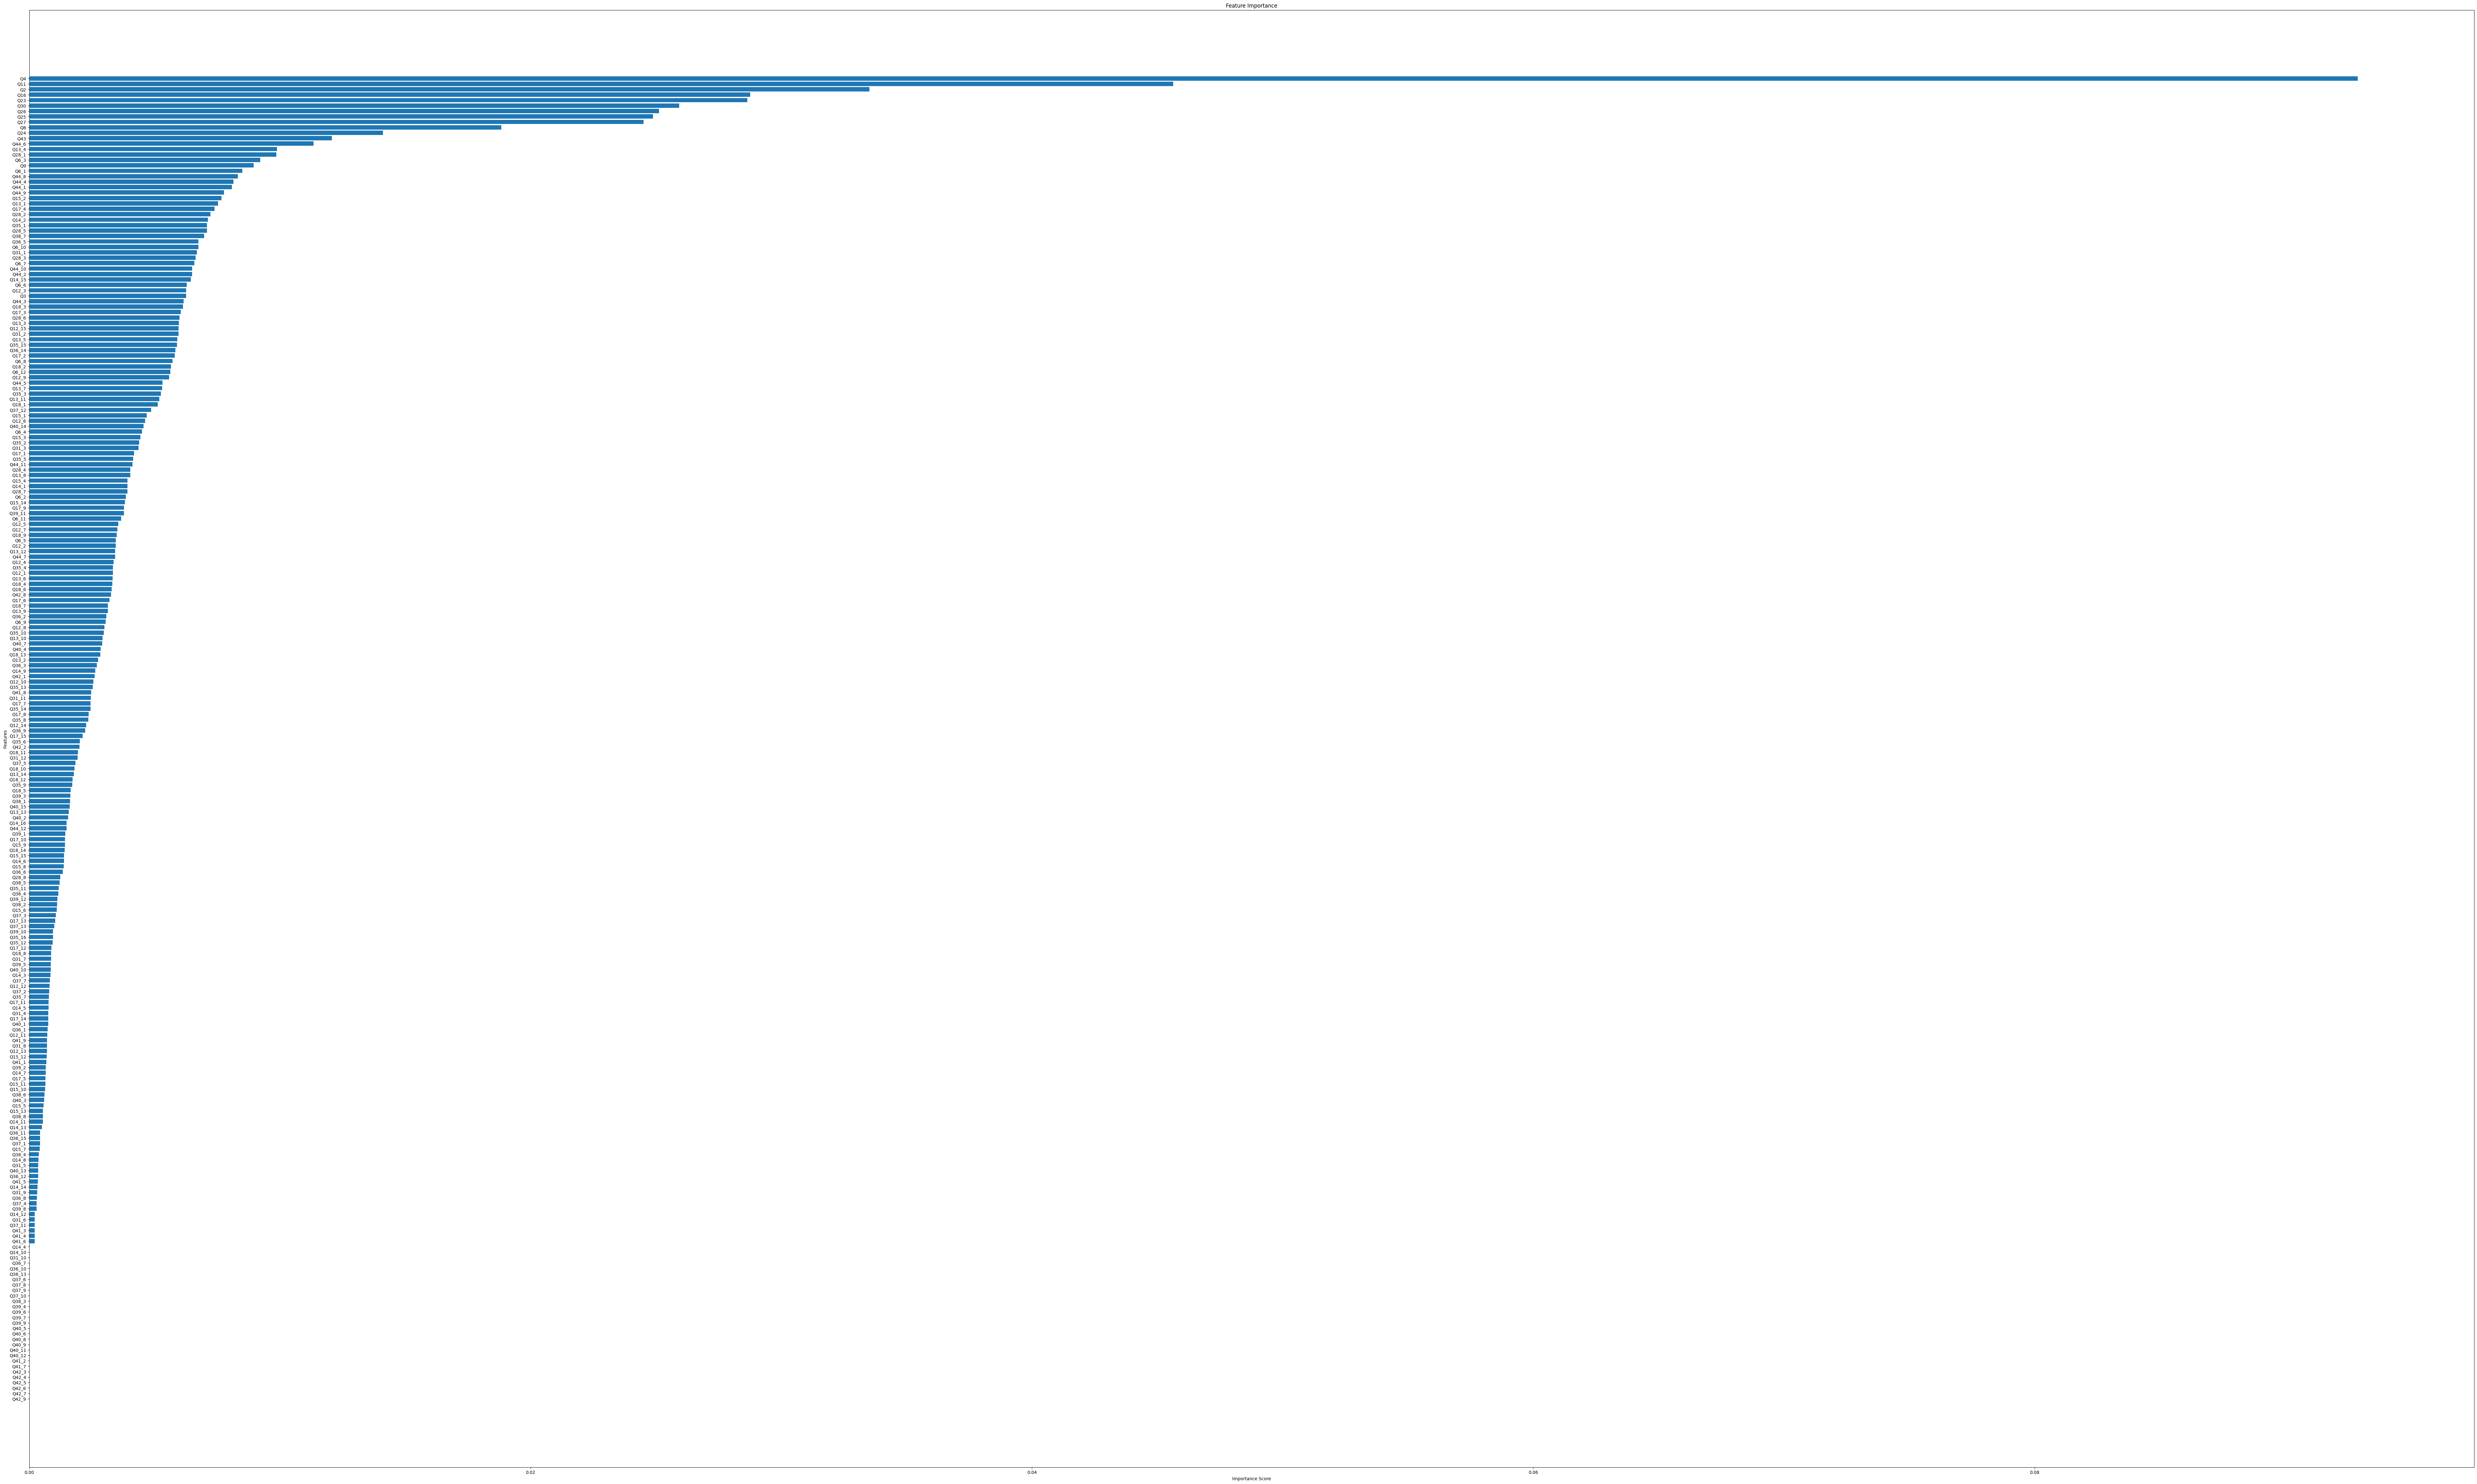

In [36]:
#decision tree
dt = tree.DecisionTreeClassifier(random_state=0)
dt.fit(X_train,y_train) # fit dt
importance = dt.feature_importances_ # find importance order
importance_copy = importance.copy()
feature_names = cat_cols # Get the column names (feature names)
feature_importance_dict = dict(zip(feature_names, importance)) # Create a dictionary to match feature names with importance scores
feature_importance_dict = dict(sorted(feature_importance_dict.items(), key=lambda x:x[1], reverse=True))

for feature, score in feature_importance_dict.items(): # Print the feature names and their importance scores
  print(f'Feature: {feature}, Importance: {score:.6f}')

features = list(feature_importance_dict.keys()) # Extract feature names and importance scores
importance_scores = list(feature_importance_dict.values())

plt.figure(figsize=(100, 60))  # Create a bar plot
plt.barh(features, importance_scores)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.gca().invert_yaxis()
plt.title('Feature Importance')
plt.show()

From the feature importance plot above, we can see the following features have obviously less importance: Q38, Q41, Q39, Q37, Q42, and Q40. It's also obvious that Q11 is the most important feature.

Based on the results from Cramer's V and decision tree, we can drop the following features: Q38, Q41, Q39, Q37, Q42, and Q40.

In [37]:
#drop the list of less important features: ['Q38','Q41','Q39','Q37','Q42','Q40']
# X_y_train = X_y_train.drop(columns=['Q38','Q41','Q39','Q37','Q42','Q40'])
# X_y_test = X_y_test.drop(columns=['Q38','Q41','Q39','Q37','Q42','Q40'])

columns_to_drop = ['Q38', 'Q41', 'Q39', 'Q37', 'Q42', 'Q40']
X_y_train = X_y_train.drop(columns=[col for col in X_y_train.columns if col.startswith(tuple(columns_to_drop))])
X_y_test = X_y_test.drop(columns=[col for col in X_y_test.columns if col.startswith(tuple(columns_to_drop))])

In [38]:
X_y_train.iloc[0:4,:] # show 4 rows of the dataset

,Q2,Q3,Q4,Q6_1,Q6_2,Q6_3,Q6_4,Q6_5,Q6_6,Q6_7,Q6_8,Q6_9,Q6_10,Q6_11,Q6_12,Q8,Q9,Q11,Q12_1,Q12_2,Q12_3,Q12_4,Q12_5,Q12_6,Q12_7,Q12_8,Q12_9,Q12_10,Q12_11,Q12_12,Q12_13,Q12_14,Q12_15,Q13_1,Q13_2,Q13_3,Q13_4,Q13_5,Q13_6,Q13_7,Q13_8,Q13_9,Q13_10,Q13_11,Q13_12,Q13_13,Q13_14,Q14_1,Q14_2,Q14_3,Q14_4,Q14_5,Q14_6,Q14_7,Q14_8,Q14_9,Q14_10,Q14_11,Q14_12,Q14_13,Q14_14,Q14_15,Q14_16,Q15_1,Q15_2,Q15_3,Q15_4,Q15_5,Q15_6,Q15_7,Q15_8,Q15_9,Q15_10,Q15_11,Q15_12,Q15_13,Q15_14,Q15_15,Q16,Q17_1,Q17_2,Q17_3,Q17_4,Q17_5,Q17_6,Q17_7,Q17_8,Q17_9,Q17_10,Q17_11,Q17_12,Q17_13,Q17_14,Q17_15,Q18_1,Q18_2,Q18_3,Q18_4,Q18_5,Q18_6,Q18_7,Q18_8,Q18_9,Q18_10,Q18_11,Q18_12,Q18_13,Q18_14,Q23,Q24,Q25,Q26,Q27,Q28_1,Q28_2,Q28_3,Q28_4,Q28_5,Q28_6,Q28_7,Q28_8,Q30,Q31_1,Q31_2,Q31_3,Q31_4,Q31_5,Q31_6,Q31_7,Q31_8,Q31_9,Q31_10,Q31_11,Q31_12,Q35_1,Q35_2,Q35_3,Q35_4,Q35_5,Q35_6,Q35_7,Q35_8,Q35_9,Q35_10,Q35_11,Q35_12,Q35_13,Q35_14,Q35_15,Q35_16,Q36_1,Q36_2,Q36_3,Q36_4,Q36_5,Q36_6,Q36_7,Q36_8,Q36_9,Q36_10,Q36_11,Q36_12,Q36_13,Q36_14,Q36_15,Q43,Q44_1,Q44_2,Q44_3,Q44_4,Q44_5,Q44_6,Q44_7,Q44_8,Q44_9,Q44_10,Q44_11,Q44_12,Q29_Encoded,Q29_buckets
2315,3,0,0,1,0,1,0,0,1,0,0,0,0,0,1,4,2,5,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,3,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,2,3,0,3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,1,1,1,0,0,1.0,"10,000-19,999"
4844,2,1,0,0,0,1,0,0,0,1,0,0,1,0,0,3,0,2,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,2,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,1,2,1,2,2,1,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,"0-9,999"
4186,4,1,2,1,0,1,0,0,0,0,0,0,1,0,0,4,2,5,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,1,1,1,0,1,0,0,0,1,0,0,0,0,2,2,0,1,4,0,0,0,0,1,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0.0,"0-9,999"
5481,2,0,7,1,0,0,0,0,0,0,0,0,0,0,0,4,1,3,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,1,1,1,1,0,1,1,1,0,0,0,1,1,0,0,1,1,1,0,0,0,0,0,1,1,0,0,0,0,4,3,2,2,4,1,0,1,0,1,0,0,0,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,9.0,"90,000-99,999"


*Appendix for part 2*

**the features:**

'Duration (in seconds)': drop! (time spent on the survey)

'Q2': ordinal encoding (older with larger number)

'Q3': consider only selecting man and woman data, then label encoding (man:1, woman:0)

'Q4': drop! (country)

'Q5': drop! (only have one category)

'Q6': one-hot encoding, then feature aggregation, total platforms?

'Q7': drop! (helpful platforms, subjective)

'Q8': ordinal encoding (higher education level with higher number)

'Q9': label encoding (yes:1, no:0)

'Q11': ordinal encoding (longer programming with lager number)

'Q12': one-hot encoding, then feature aggregation, total languages?

'Q13': one-hot encoding, then feature aggregation, total IDEs?  

'Q14': one-hot encoding, then feature aggregation, total notebook products?

'Q15': one-hot encoding, then feature aggregation, total libraries?

'Q16': ordinal encoding (longer use ML with larger number)

'Q17': one-hot encoding, then feature aggregation, total frameworks?

'Q18': one-hot encoding, then feature aggregation, total ML algorithms?

'Q21': drop! (download ML model weights from services)

'Q23': target encoding (job title)

'Q24': target encoding (employer)

'Q25': ordinal encoding (larger company size larger number)

'Q26': ordinal encoding (more people/workload, larger number)

'Q27': ordinal encoding (more experience with ML methods to business, larger number)

'Q28': one-hot encoding, then feature aggregation, total activities/day?

'Q29': drop! (it's our target)

'Q30': ordinal encoding (more money spent larger number)

'Q31': one-hot encoding, then feature aggregation, total cloud computing platforms?

'Q35': one-hot encoding, then feature aggregation, total data products?

'Q36': one-hot encoding, then feature aggregation, total business intelligence tools?

'Q37': one-hot encoding, then feature aggregation, total managed ML tools?

'Q38': one-hot encoding, then feature aggregation, total automated ML tools?

'Q39': one-hot encoding, then feature aggregation, total products to serve ML model?

'Q40': one-hot encoding, then feature aggregation, total ML monitoring tools?

'Q41': one-hot encoding, then feature aggregation, total ethical ML tools?

'Q42': one-hot encoding, then feature aggregation, total specialized hardware?

'Q43': ordinal encoding (larger TPU frequency larger number)

'Q44': one-hot encoding, then feature aggregation, total DS media sources?

**the target:**

'Q29_Encoded'

'Q29_buckets'

#3. Model implementation

**special note*

In part 3, the function "ordinal_logistic_regression" accepts a dataframe containing the features and the target for the training set. It outputs ordinal_probs as well as ordinal_class. Ordinal_probs is probability of belonging to each of the salary bucket, as required for this assignment. For the sake of convinence, I also incorporate the predicted classes in the same function, which is later used for calculating accuracy. It also applies for the function "ordinal_logistic_regression_cv", which is a modified version for cross-validation purpose.

*The logic of the ordinal multi-class logistic regression algorithm:

I have a cleaned and encoded dataset, from which I obtained features X and my multi-class target y. In y, there are total n classes, i.e., [0,1,2,...,n-1]. I will solve total (n-1) binary logistic regression problems.

For problem no.0, relabel y to have class "0" containing [0] and class "1" containing [1,2,...,n-1]. Then I get the probability in class "0", p(0,0) (the first 1 means problem no.0, the second 0 means class "0"), and the probability in class "1", p(0,1). Then I get the probability of being class [0], which is p(0,0).

For problem no.1, relabel y to have class "0" containing [0,1] and class "1" containing [2,3,...,n-1]. Then I get the probability in class "0", p(1,0) (the first 1 means problem no.1, the second 0 means class "0"), and the probability in class "1", p(1,1). Then I calculate the probability of being class [1], which is p(1,0) - p(0,0).

For problem no.2, relabel y to have class "0" containing [0,1,2] and class "1" containing [3,4,...,n-1]. Then I get the probability in class "0", p_(2,0) (the first 2 means problem no.2, the second 0 means class "0"), and the probability in class "1", p(2,1). Then I calculate the probability of being class [2], which is p(2,0) - p(1,0).

...

For the last problem no.(n-2), relabel y to have class "0" containing [0,1,…,n-2] and class "1" containing [n-1]. Then I get the probability in class "0", p(n-2,0) (the first (n-2) means problem no.(n-2), the second 0 means class "0"), and the probability in class "1", p(n-2,1). Then I calculate the probability of being class [n-2], which is p(n-2,0) - p(n-3,0).

Lastly, I can calculate the probability of being the last class [n-1], which is p(n-1,1).


In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold

In [40]:
print('The class of the salary:')
print(get_unique(data1,['Q29_Encoded'],''))

The class of the salary:
[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0]


In [41]:
#implement ordinal logistic regression

def ordinal_logistic_regression(X_y_df):
  X_y_train = X_y_df.copy()
  classes = get_unique(data1,['Q29_Encoded'],'') # get the salary classes
  n_classes = len(classes) # total number of classes, n
  ordinal_probs_0 = np.empty((X_y_train.shape[0], n_classes-1), dtype=float) # to store probabilities of being in relabeled class 0

  for n in range(n_classes - 1):
    X_y_train['Q29_Encoded'] = (X_y_train['Q29_Encoded'] >= n+1).astype(int) # relabel the classes into class 0 and calss 1 for the binary logistic regression problem
    X_train = X_y_train.iloc[:,:-2].values # features of training set
    y_train = X_y_train.iloc[:,-2].values # target of training set
    y_train = y_train.reshape(-1,1).ravel() # reshape single column array
    model = LogisticRegression(solver='liblinear',C=1.0) # my binary logistic regression model
    model.fit(X_train, y_train) # fit to training set
    probs_class_0 = model.predict_proba(X_train)[:, 0] # get the probability of being in relabeled class 0
    ordinal_probs_0[:,n] = probs_class_0 # add to the array
    X_y_train = X_y_df.copy()

  ordinal_probs = np.empty((X_y_train.shape[0], n_classes), dtype=float) # to store our outputs the probabilities of row data points being in all salary classes
  for n in range(n_classes - 1):
    if n == 0:
      ordinal_probs[:,n] = ordinal_probs_0[:,n] # Probability of being in salary class 0 for the first class
    else:
      ordinal_probs[:,n] = ordinal_probs_0[:,n] - ordinal_probs_0[:,n-1] # Probability of being in salary class n for other classes
  sum = np.sum(ordinal_probs[:,:-1], axis=1, keepdims=True) # for each row, calculate the sum of probabilities in salary class 0,1,...,n-2
  ordinal_probs[:,-1] = 1 - sum.reshape((-1,)) # calculate the probability of being in salary class n-1 for the last class
  ordinal_class = np.argmax(ordinal_probs, axis=1).reshape(-1, 1)
  return ordinal_probs,ordinal_class


In [42]:
# ordinal_probs,ordinal_class = ordinal_logistic_regression(X_y_train_backup2)

In [43]:
# accuracy = accuracy_score(X_y_train.iloc[:,-2].values,ordinal_class)
# print(accuracy)

In [44]:
X_y_train.iloc[0:4,:]

,Q2,Q3,Q4,Q6_1,Q6_2,Q6_3,Q6_4,Q6_5,Q6_6,Q6_7,Q6_8,Q6_9,Q6_10,Q6_11,Q6_12,Q8,Q9,Q11,Q12_1,Q12_2,Q12_3,Q12_4,Q12_5,Q12_6,Q12_7,Q12_8,Q12_9,Q12_10,Q12_11,Q12_12,Q12_13,Q12_14,Q12_15,Q13_1,Q13_2,Q13_3,Q13_4,Q13_5,Q13_6,Q13_7,Q13_8,Q13_9,Q13_10,Q13_11,Q13_12,Q13_13,Q13_14,Q14_1,Q14_2,Q14_3,Q14_4,Q14_5,Q14_6,Q14_7,Q14_8,Q14_9,Q14_10,Q14_11,Q14_12,Q14_13,Q14_14,Q14_15,Q14_16,Q15_1,Q15_2,Q15_3,Q15_4,Q15_5,Q15_6,Q15_7,Q15_8,Q15_9,Q15_10,Q15_11,Q15_12,Q15_13,Q15_14,Q15_15,Q16,Q17_1,Q17_2,Q17_3,Q17_4,Q17_5,Q17_6,Q17_7,Q17_8,Q17_9,Q17_10,Q17_11,Q17_12,Q17_13,Q17_14,Q17_15,Q18_1,Q18_2,Q18_3,Q18_4,Q18_5,Q18_6,Q18_7,Q18_8,Q18_9,Q18_10,Q18_11,Q18_12,Q18_13,Q18_14,Q23,Q24,Q25,Q26,Q27,Q28_1,Q28_2,Q28_3,Q28_4,Q28_5,Q28_6,Q28_7,Q28_8,Q30,Q31_1,Q31_2,Q31_3,Q31_4,Q31_5,Q31_6,Q31_7,Q31_8,Q31_9,Q31_10,Q31_11,Q31_12,Q35_1,Q35_2,Q35_3,Q35_4,Q35_5,Q35_6,Q35_7,Q35_8,Q35_9,Q35_10,Q35_11,Q35_12,Q35_13,Q35_14,Q35_15,Q35_16,Q36_1,Q36_2,Q36_3,Q36_4,Q36_5,Q36_6,Q36_7,Q36_8,Q36_9,Q36_10,Q36_11,Q36_12,Q36_13,Q36_14,Q36_15,Q43,Q44_1,Q44_2,Q44_3,Q44_4,Q44_5,Q44_6,Q44_7,Q44_8,Q44_9,Q44_10,Q44_11,Q44_12,Q29_Encoded,Q29_buckets
2315,3,0,0,1,0,1,0,0,1,0,0,0,0,0,1,4,2,5,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,3,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,2,3,0,3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,1,1,1,0,0,1.0,"10,000-19,999"
4844,2,1,0,0,0,1,0,0,0,1,0,0,1,0,0,3,0,2,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,2,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,1,2,1,2,2,1,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,"0-9,999"
4186,4,1,2,1,0,1,0,0,0,0,0,0,1,0,0,4,2,5,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,1,1,1,0,1,0,0,0,1,0,0,0,0,2,2,0,1,4,0,0,0,0,1,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0.0,"0-9,999"
5481,2,0,7,1,0,0,0,0,0,0,0,0,0,0,0,4,1,3,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,1,1,1,1,0,1,1,1,0,0,0,1,1,0,0,1,1,1,0,0,0,0,0,1,1,0,0,0,0,4,3,2,2,4,1,0,1,0,1,0,0,0,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,9.0,"90,000-99,999"


In [45]:
def ordinal_logistic_regression_cv(X_y_tr_df,X_y_vl_df,c=1.0,solver='liblinear'): # this function outputs the ordinal_probs and ordinal_class for the validation set by fitting a model to the training set
  X_y_train = X_y_tr_df.copy()
  X_y_val = X_y_vl_df.copy()
  classes = get_unique(data1,['Q29_Encoded'],'') # get the salary classes
  n_classes = len(classes) # total number of classes, n
  ordinal_probs_0 = np.empty((X_y_val.shape[0], n_classes-1), dtype=float) # to store probabilities of being in relabeled class 0 (validation set)

  for n in range(n_classes - 1):
    X_y_train['Q29_Encoded'] = (X_y_train['Q29_Encoded'] >= n+1).astype(int) # relabel the classes into class 0 and calss 1 for the binary logistic regression problem
    X_train = X_y_train.iloc[:,:-2].values # features of training set
    X_val = X_y_val.iloc[:,:-2].values # features of validation set
    y_train = X_y_train.iloc[:,-2].values # target of training set
    y_train = y_train.reshape(-1,1).ravel() # reshape single column array
    model = LogisticRegression(solver=solver,C=c) # my binary logistic regression model
    model.fit(X_train, y_train) # fit to training set
    probs_class_0 = model.predict_proba(X_val)[:, 0] # get the probability of being in relabeled class 0 using the validation set
    ordinal_probs_0[:,n] = probs_class_0 # add to the array
    X_y_train = X_y_tr_df.copy()

  ordinal_probs = np.empty((X_y_val.shape[0], n_classes), dtype=float) # to store our outputs the probabilities of row data points being in all salary classes (validation set)
  for n in range(n_classes - 1):
    if n == 0:
      ordinal_probs[:,n] = ordinal_probs_0[:,n] # Probability of being in salary class 0 for the first class
    else:
      ordinal_probs[:,n] = ordinal_probs_0[:,n] - ordinal_probs_0[:,n-1] # Probability of being in salary class n for other classes
  sum = np.sum(ordinal_probs[:,:-1], axis=1, keepdims=True) # for each row, calculate the sum of probabilities in salary class 0,1,...,n-2
  ordinal_probs[:,-1] = 1 - sum.reshape((-1,)) # calculate the probability of being in salary class n-1 for the last class
  ordinal_class = np.argmax(ordinal_probs, axis=1).reshape(-1, 1)
  return ordinal_probs,ordinal_class

def OLR_10F_c(X_y_train,c=1.0,solver='liblinear'):
  n_splits = 10 # Define the number of folds (k)
  kf = KFold(n_splits=n_splits, shuffle=True, random_state=None) # Initialize the KFold object
  accuracy_list = [] # to store accuracy score for each fold
  f1_list = [] # to store F1 score for each fold
  sq_e_y_val = [] # (E[Y])^2 for all folds, also known as bias^2
  e_y_sq_val = [] # E[Y^2] for all folds, also known as bias^2 + variance
  variance_val = [] # variance for all folds

  for i, (train_index, val_index) in enumerate(kf.split(X_y_train)): # Iterate over the splits
    X_y_tr = X_y_train.iloc[train_index] # X_y_df[train_index] contains the training data for this fold
    X_y_vl = X_y_train.iloc[val_index] # X_y_df[val_index] contains the validation data for this fold
    ordinal_probs,ordinal_class = ordinal_logistic_regression_cv(X_y_tr,X_y_vl,c=c,solver=solver)
    accuracy = accuracy_score(X_y_vl.iloc[:,-2].values,ordinal_class) # calculate accuracy
    f1 = f1_score(X_y_vl.iloc[:,-2].values,ordinal_class,average='weighted') # calculate weighted F1 score
    accuracy_list.append(accuracy)
    f1_list.append(f1)

    y = X_y_vl.iloc[:,-2].values # the true class
    sq_e_y = np.zeros((ordinal_probs.shape[0], 1)) # (E[Y])^2
    e_y_sq = np.zeros((ordinal_probs.shape[0], 1)) # E[Y^2]
    for j in range(ordinal_probs.shape[0]):
      y_prob = ordinal_probs[j]
      true_class = y[j]

      e_y = np.sum(y_prob * np.arange(len(y_prob))) - true_class # E[Y]
      sq_e_y[j] = (e_y ** 2) # Calculate (E[Y])^2 for this row
      e_y_sq[j] = np.sum((y_prob * (np.arange(len(y_prob)) - true_class) ** 2)) # Calculate E[Y^2] for this row

    sq_e_y_val.append(sq_e_y) # add to the list of (E[Y])^2 for all folds
    e_y_sq_val.append(e_y_sq) # add to the list of E[Y^2] for all folds
    variance_val.append(e_y_sq - sq_e_y) # add to the list of variance for all folds

  accuracy_mean = sum(accuracy_list)/len(accuracy_list) # the average of accuracy across folds
  f1_mean = sum(f1_list)/len(f1_list) # the average of F1 score across folds
  accuracy_var = sum((x - accuracy_mean) ** 2 for x in accuracy_list)/len(accuracy_list) # the variance of accuracy across folds
  bias_sq_list = []
  variance_list = []
  for i in range(n_splits):
    bias_sq_list.append(sq_e_y_val[i].mean())
    variance_list.append(variance_val[i].mean())
  return accuracy_mean,f1_mean,accuracy_var,bias_sq_list,variance_list


In [46]:
accuracy_mean_list = []
f1_mean_list = []
accuracy_var_list = []
bias_avg_list = []
variance_avg_list = []
bias_full_list = []
variance_full_list = []
c_val_list = np.arange(0.1, 1.1, 0.1).tolist()

for c in c_val_list:
  accuracy_mean,f1_mean,accuracy_var,bias_sq_list,variance_list = OLR_10F_c(X_y_train,c=c,solver='liblinear')
  accuracy_mean_list.append(accuracy_mean)
  f1_mean_list.append(f1_mean)
  accuracy_var_list.append(accuracy_var)
  bias_avg_list.append(sum(bias_sq_list)/len(bias_sq_list))
  variance_avg_list.append(sum(variance_list)/len(variance_list))
  bias_full_list = bias_full_list + bias_sq_list
  variance_full_list = variance_full_list + variance_list


list of mean accuracy score for each c:
[0.4061719349661573, 0.4029573524654119, 0.3986818150100545, 0.3979691197087052, 0.3997506993738938, 0.40064577108747096, 0.4001116460819203, 0.40046910384988677, 0.40063562144365994, 0.3970753167006045]
list of mean F1 score for each c:
[0.32717072207764264, 0.3301219457198479, 0.32898586546498765, 0.3292906348669833, 0.33365833961833147, 0.33389824532882784, 0.3356566253466764, 0.3350160987970184, 0.33453243600086846, 0.33228891631605384]
list of variance of accuracy score for each c:
[0.0005191000595868042, 0.0004892773498285462, 0.0007713446181378905, 0.00012711197206943494, 0.0002931110802330084, 0.0003957108066473654, 0.00032646755768903914, 0.0005087874303282066, 0.00045853240240924356, 0.00015972774680084683]


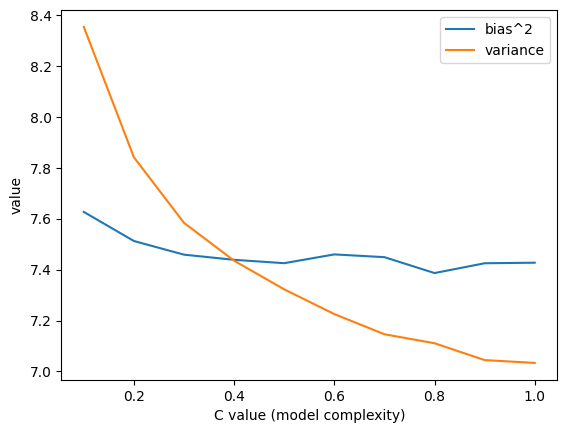

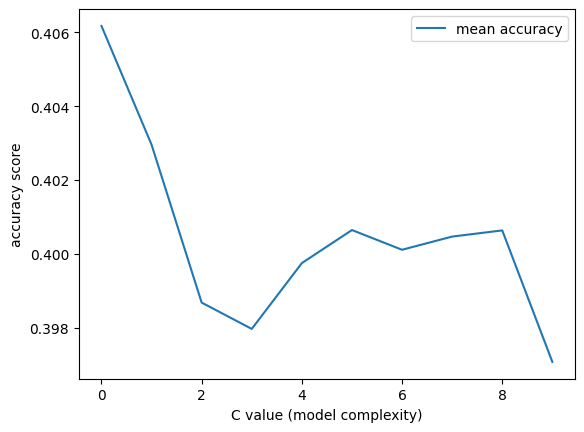

In [47]:
print('list of mean accuracy score for each c:')
print(accuracy_mean_list)
print('list of mean F1 score for each c:')
print(f1_mean_list)
print('list of variance of accuracy score for each c:')
print(accuracy_var_list)
# print(bias_avg_list)
# print(variance_avg_list)

x = c_val_list # range(len(bias_avg_list))
plt.plot(x, bias_avg_list, label='bias^2')
plt.plot(x, variance_avg_list, label='variance')
plt.xlabel('C value (model complexity)') # larger x value, larger c value, more complex model
plt.ylabel('value')
plt.legend()
plt.show()

x = range(len(accuracy_mean_list))
plt.plot(x, accuracy_mean_list, label='mean accuracy')
plt.xlabel('C value (model complexity)')
plt.ylabel('accuracy score')
plt.legend()
plt.show()

#4. Model tuning

In [48]:
candidate_solver = ['saga','liblinear','newton-cholesky'] # a list of solvers to test
candidate_c = np.arange(0.1, 1.1, 0.1).tolist() # a list of parameter c to test
grid_search_df = pd.DataFrame(columns=['solver', 'c', 'f1 score'], index=range(len(candidate_c)*len(candidate_solver))) # dataframe to store the results
index = 0
for solver in candidate_solver: # in two loops, compute the f1 score for all combinations of solver and parameter c
  for c in candidate_c:
    _, f1_mean, _, _, _ = OLR_10F_c(X_y_train, c=c, solver=solver)
    grid_search_df.loc[index] = [solver, c, f1_mean]
    index += 1

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

In [49]:
grid_search_df # display the results

,solver,c,f1 score
0,saga,0.1,0.330718
1,saga,0.2,0.332011
2,saga,0.3,0.328452
3,saga,0.4,0.334311
4,saga,0.5,0.330115
5,saga,0.6,0.333493
6,saga,0.7,0.333846
7,saga,0.8,0.334495
8,saga,0.9,0.334624
9,saga,1.0,0.332219


In [50]:
model_params = grid_search_df[grid_search_df['f1 score'] == grid_search_df['f1 score'].max()] # get the set of solver and c that have the highest F1 score

In [51]:
model_solver = model_params.iloc[0,0]# this is the solver we will use
model_c = model_params.iloc[0,1] # this is the parameter c we will use

In [52]:
print(model_solver)
print(model_c)

liblinear
0.9


In [53]:
def ordinal_logistic_regression_importance(X_y_df): # modified from the previous, it fit to the training set and compute the feature importance
  X_y_train = X_y_df.copy()
  classes = get_unique(data1,['Q29_Encoded'],'') # get the salary classes
  n_classes = len(classes) # total number of classes, n
  ordinal_probs_0 = np.empty((X_y_train.shape[0], n_classes-1), dtype=float) # to store probabilities of being in relabeled class 0

  feature_importance_scores = [] # Get the coefficients for each model and calculate feature importance
  for n in range(n_classes - 1):
    X_y_train['Q29_Encoded'] = (X_y_train['Q29_Encoded'] >= n+1).astype(int) # relabel the classes into class 0 and calss 1 for the binary logistic regression problem
    X_train = X_y_train.iloc[:,:-2].values # features of training set
    y_train = X_y_train.iloc[:,-2].values # target of training set
    y_train = y_train.reshape(-1,1).ravel() # reshape single column array
    model = LogisticRegression(solver=model_solver,C=model_c) # use optimal specifications for my binary logistic regression model
    model.fit(X_train, y_train) # fit to training set

    coefficients = model.coef_[0]
    feature_importance = abs(coefficients) # Calculate feature importance based on the magnitude of coefficients
    feature_importance_scores.append(feature_importance)

    probs_class_0 = model.predict_proba(X_train)[:, 0] # get the probability of being in relabeled class 0
    ordinal_probs_0[:,n] = probs_class_0 # add to the array
    X_y_train = X_y_df.copy()

  mean_importance = np.mean(feature_importance_scores, axis=0) # Average feature importance scores
  feature_importance = mean_importance / mean_importance.sum() # Normalize the aggregated feature importance to sum to 1

  ordinal_probs = np.empty((X_y_train.shape[0], n_classes), dtype=float) # to store our outputs the probabilities of row data points being in all salary classes
  for n in range(n_classes - 1):
    if n == 0:
      ordinal_probs[:,n] = ordinal_probs_0[:,n] # Probability of being in salary class 0 for the first class
    else:
      ordinal_probs[:,n] = ordinal_probs_0[:,n] - ordinal_probs_0[:,n-1] # Probability of being in salary class n for other classes
  sum = np.sum(ordinal_probs[:,:-1], axis=1, keepdims=True) # for each row, calculate the sum of probabilities in salary class 0,1,...,n-2
  ordinal_probs[:,-1] = 1 - sum.reshape((-1,)) # calculate the probability of being in salary class n-1 for the last class
  ordinal_class = np.argmax(ordinal_probs, axis=1).reshape(-1, 1)
  return ordinal_probs,ordinal_class,feature_importance

In [54]:
_,_,importance = ordinal_logistic_regression_importance(X_y_train) # get feature importance

Feature: Q14_11, Importance: 0.025465
Feature: Q31_9, Importance: 0.018355
Feature: Q14_10, Importance: 0.017390
Feature: Q36_13, Importance: 0.015492
Feature: Q15_13, Importance: 0.014830
Feature: Q31_4, Importance: 0.014652
Feature: Q15_12, Importance: 0.013251
Feature: Q14_4, Importance: 0.012898
Feature: Q36_8, Importance: 0.011148
Feature: Q35_10, Importance: 0.010652
Feature: Q15_9, Importance: 0.010579
Feature: Q36_12, Importance: 0.010329
Feature: Q35_15, Importance: 0.010179
Feature: Q12_10, Importance: 0.009795
Feature: Q35_13, Importance: 0.009730
Feature: Q4, Importance: 0.009599
Feature: Q35_6, Importance: 0.009509
Feature: Q17_11, Importance: 0.009378
Feature: Q31_8, Importance: 0.009282
Feature: Q12_14, Importance: 0.009258
Feature: Q17_5, Importance: 0.009142
Feature: Q14_2, Importance: 0.009107
Feature: Q31_6, Importance: 0.008905
Feature: Q14_13, Importance: 0.008872
Feature: Q31_10, Importance: 0.008639
Feature: Q36_10, Importance: 0.008298
Feature: Q17_14, Importanc

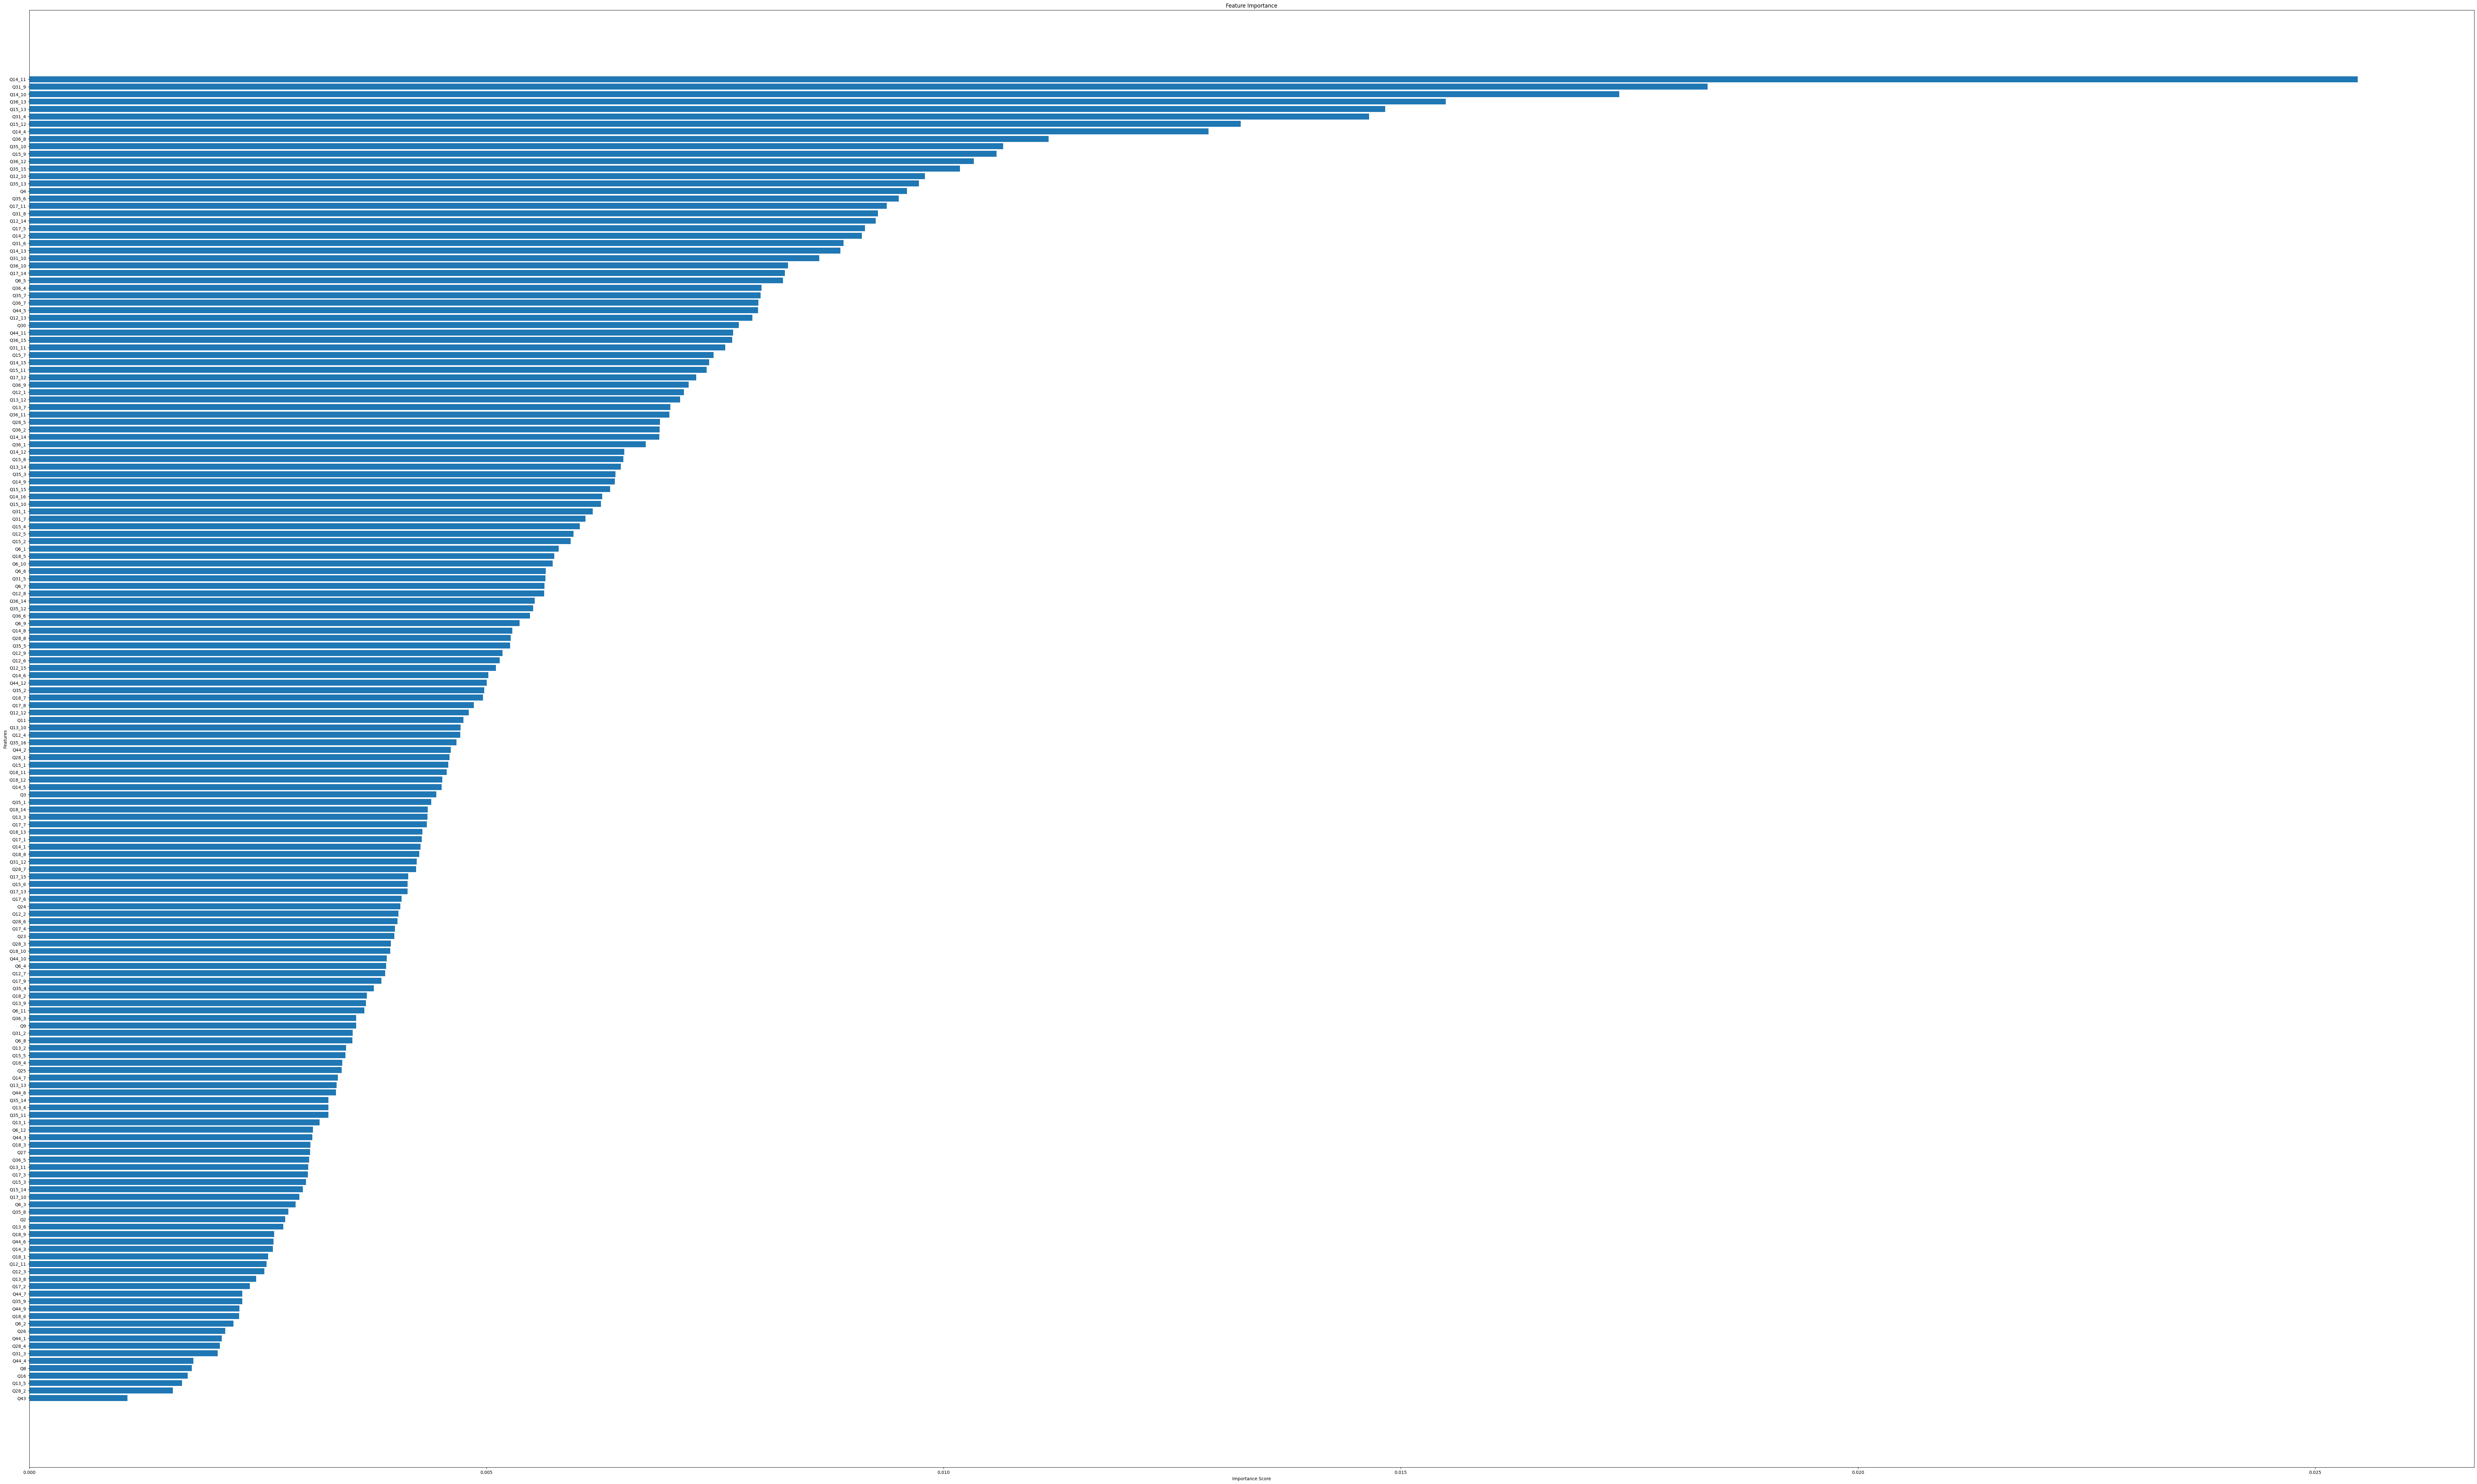

In [55]:
feature_names = X_y_train.columns.to_list()[:-2] # Get the column names (feature names)
feature_importance_dict = dict(zip(feature_names, importance)) # Create a dictionary to match feature names with importance scores
feature_importance_dict = dict(sorted(feature_importance_dict.items(), key=lambda x:x[1], reverse=True))

for feature, score in feature_importance_dict.items(): # Print the feature names and their importance scores
  print(f'Feature: {feature}, Importance: {score:.6f}')

features = list(feature_importance_dict.keys()) # Extract feature names and importance scores
importance_scores = list(feature_importance_dict.values())

plt.figure(figsize=(100, 60))  # Create a bar plot
plt.barh(features, importance_scores)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.gca().invert_yaxis()
plt.title('Feature Importance')
plt.show()

#5. Testing

In [56]:
def ordinal_logistic_regression_train(X_y_train_df):
  X_y_train = X_y_train_df.copy()
  classes = get_unique(data1,['Q29_Encoded'],'') # get the salary classes
  n_classes = len(classes) # total number of classes, n
  ordinal_probs_0 = np.empty((X_y_train.shape[0], n_classes-1), dtype=float) # to store probabilities of being in relabeled class 0

  for n in range(n_classes - 1):
    X_y_train['Q29_Encoded'] = (X_y_train['Q29_Encoded'] >= n+1).astype(int) # relabel the classes into class 0 and calss 1 for the binary logistic regression problem
    X_train = X_y_train.iloc[:,:-2].values # features of training set
    y_train = X_y_train.iloc[:,-2].values # target of training set
    y_train = y_train.reshape(-1,1).ravel() # reshape single column array
    model = LogisticRegression(solver=model_solver,C=model_c) # use the optimal specification for my binary logistic regression model
    model.fit(X_train, y_train) # fit to training set
    probs_class_0 = model.predict_proba(X_train)[:, 0] # get the probability of being in relabeled class 0
    ordinal_probs_0[:,n] = probs_class_0 # add to the array
    X_y_train = X_y_train_df.copy()

  ordinal_probs = np.empty((X_y_train.shape[0], n_classes), dtype=float) # to store our outputs the probabilities of row data points being in all salary classes
  for n in range(n_classes - 1):
    if n == 0:
      ordinal_probs[:,n] = ordinal_probs_0[:,n] # Probability of being in salary class 0 for the first class
    else:
      ordinal_probs[:,n] = ordinal_probs_0[:,n] - ordinal_probs_0[:,n-1] # Probability of being in salary class n for other classes
  sum = np.sum(ordinal_probs[:,:-1], axis=1, keepdims=True) # for each row, calculate the sum of probabilities in salary class 0,1,...,n-2
  ordinal_probs[:,-1] = 1 - sum.reshape((-1,)) # calculate the probability of being in salary class n-1 for the last class
  ordinal_class = np.argmax(ordinal_probs, axis=1).reshape(-1, 1)
  return ordinal_probs,ordinal_class

def ordinal_logistic_regression_test(X_y_train_df,X_y_test_df):
  X_y_train = X_y_train_df.copy()
  X_y_test = X_y_test_df.copy()
  classes = get_unique(data1,['Q29_Encoded'],'') # get the salary classes
  n_classes = len(classes) # total number of classes, n
  ordinal_probs_0 = np.empty((X_y_test.shape[0], n_classes-1), dtype=float) # to store probabilities of being in relabeled class 0

  for n in range(n_classes - 1):
    X_y_train['Q29_Encoded'] = (X_y_train['Q29_Encoded'] >= n+1).astype(int) # relabel the classes into class 0 and calss 1 for the binary logistic regression problem
    X_train = X_y_train.iloc[:,:-2].values # features of training set
    y_train = X_y_train.iloc[:,-2].values # target of training set
    y_train = y_train.reshape(-1,1).ravel() # reshape single column array

    X_test = X_y_test.iloc[:,:-2].values # features of test set
    y_test = X_y_test.iloc[:,-2].values # target of test set
    y_test = y_test.reshape(-1,1).ravel() # reshape single column array
    model = LogisticRegression(solver=model_solver,C=model_c) # use the optimal specification for my binary logistic regression model
    model.fit(X_train, y_train) # fit to training set
    probs_class_0 = model.predict_proba(X_test)[:, 0] # get the probability of being in relabeled class 0
    ordinal_probs_0[:,n] = probs_class_0 # add to the array
    X_y_train = X_y_train_df.copy()

  ordinal_probs = np.empty((X_y_test.shape[0], n_classes), dtype=float) # to store our outputs the probabilities of row data points being in all salary classes
  for n in range(n_classes - 1):
    if n == 0:
      ordinal_probs[:,n] = ordinal_probs_0[:,n] # Probability of being in salary class 0 for the first class
    else:
      ordinal_probs[:,n] = ordinal_probs_0[:,n] - ordinal_probs_0[:,n-1] # Probability of being in salary class n for other classes
  sum = np.sum(ordinal_probs[:,:-1], axis=1, keepdims=True) # for each row, calculate the sum of probabilities in salary class 0,1,...,n-2
  ordinal_probs[:,-1] = 1 - sum.reshape((-1,)) # calculate the probability of being in salary class n-1 for the last class
  ordinal_class = np.argmax(ordinal_probs, axis=1).reshape(-1, 1)
  return ordinal_probs,ordinal_class

In [57]:
_,ordinal_class_tr = ordinal_logistic_regression_train(X_y_train) # training set
f1_training = f1_score(X_y_train.iloc[:,-2].values,ordinal_class_tr,average='weighted') # get F1 score on the training set
_,ordinal_class_tt = ordinal_logistic_regression_test(X_y_train,X_y_test) # test set
f1_test = f1_score(X_y_test.iloc[:,-2].values,ordinal_class_tt,average='weighted') # get F1 score on the training set

print('The F1 score of the training set is:',f1_training)
print('The F1 score of the test set is:',f1_test)

The F1 score of the training set is: 0.43246959556321984
The F1 score of the test set is: 0.33170579785141985


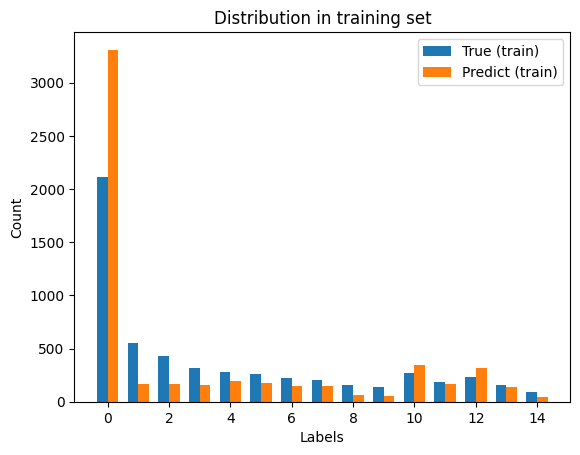

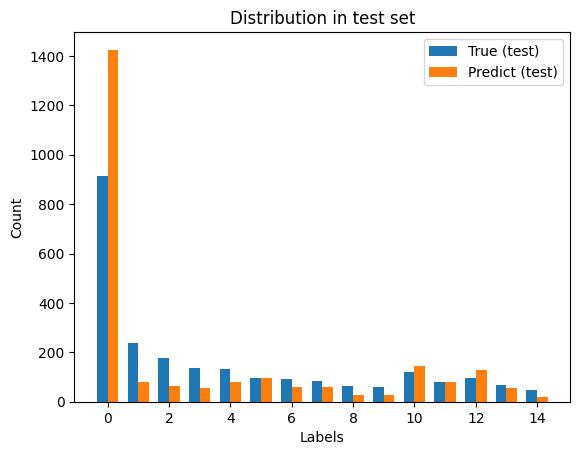

In [58]:
# Count the occurrences of each label
train_labels, train_counts = np.unique(X_y_train.iloc[:,-2].values, return_counts=True)
train_pred_labels, train_pred_counts = np.unique(ordinal_class_tr, return_counts=True)

# Determine the width of the bars
bar_width = 0.35

# Create a bar plot to visualize the distribution
plt.bar(train_labels - bar_width/2, train_counts, bar_width, label='True (train)')
plt.bar(train_pred_labels + bar_width/2, train_pred_counts, bar_width, label='Predict (train)')

plt.xlabel('Labels')
plt.ylabel('Count')
plt.legend()
plt.title('Distribution in training set')
plt.show()

# Count the occurrences of each label
test_labels, test_counts = np.unique(X_y_test.iloc[:,-2].values, return_counts=True)
test_pred_labels, test_pred_counts = np.unique(ordinal_class_tt, return_counts=True)

# Determine the width of the bars
bar_width = 0.35

# Create a bar plot to visualize the distribution
plt.bar(test_labels - bar_width/2, test_counts, bar_width, label='True (test)')
plt.bar(test_pred_labels + bar_width/2, test_pred_counts, bar_width, label='Predict (test)')

plt.xlabel('Labels')
plt.ylabel('Count')
plt.legend()
plt.title('Distribution in test set')
plt.show()

In [59]:
# #Testing cell
# test = pd.DataFrame({
#     'Q2_1': ['Python', 'Python', 'Python', np.NaN, np.NaN],
#     'Q2_2': [np.NaN, np.NaN, 'Java', 'Java', np.NaN],
#     'Q2_3': ['C', np.NaN, np.NaN, np.NaN, np.NaN],
#     'Q3_1': ['Udemy','Udemy','Udemy','Udemy', np.NaN],
#     'Q3_2': ['Coursera',np.NaN,'Coursera',np.NaN, np.NaN],
#     'Q3_3': ['DataCamp','DataCamp','DataCamp',np.NaN, np.NaN],
#     'Q3_4': ['Kaggle',np.NaN,np.NaN,np.NaN,np.NaN]
# })

# print(test)

# # test_encoded = pd.DataFrame({
# #     'Q2_1': [3, 3, 3, 0],
# #     'Q2_2': [0, 0, 2, 2],
# #     'Q2_3': [1, 0, 0, 0],
# #     'Q3_1': [4, 4, 4, 4],
# #     'Q3_2': [2, 0, 2, 0],
# #     'Q3_3': [3, 3, 3, 0],
# #     'Q3_4': [1, 0, 0, 0]
# # })
# # print(test_encoded)

# def fill_na(df,Q_col,filler):
#   df[Q_col] = df[Q_col].fillna(filler)
#   return df

# def get_col(df,Q_num):
#   Q_col = [col for col in df if col.startswith(Q_num)]
#   return Q_col

# def get_unique(df,df_col,filler):
#   unique_entries = []
#   for col in df_col:
#     unique_entries.extend(df[col].unique())
#   unique_entries = [entry for entry in set(unique_entries) if entry != filler]
#   return unique_entries

# def get_frequency(df,unique_entries,df_col):
#   value_counts = {}
#   for col in df_col:
#     for value in unique_entries:
#       count = (df[col] == value).sum()  # number of times of each unique value shows in each column
#       if value in value_counts:
#         value_counts[value] += count # add the total counts to the corresponding language
#       else:
#         value_counts[value] = count
#   return value_counts

# def freq_oneh_encode(freq_dict):
#   freq_dict = freq_dict
#   # sorted_freq = sorted(freq_dict.items(), key=lambda x: x[1], reverse=False) # Sort the dictionary by frequency
#   # label_mapping = {var: label + 1 for label, (var, _) in enumerate(sorted_freq)} # Create a mapping from variable to label
#   # encoded_labels = [label_mapping[var] for var in freq_dict.keys()] # Use the mapping to encode your variables
#   sorted_freq = sorted(freq_dict.items(), key=lambda x: x[1])
#   freq_encode = {var: label + 1 for label, (var, _) in enumerate(sorted_freq)}
#   oneh_encode = {key: 1 for key in freq_encode.keys()}
#   return freq_encode,oneh_encode

# def mode_multi_col(df,Q_col,col_fill,filler):
#   all_nan = test[Q_col].isna().all(axis=1)
#   df.loc[all_nan, col_fill] = filler
#   return df

# Q2_col = get_col(test,'Q2')
# test = mode_multi_col(test,Q2_col,'Q2_1','Python')
# test = fill_na(test,Q2_col,'Unknown')
# print(test)
# unique_langs = get_unique(test,Q2_col,'Unknown')
# lang_counts = get_frequency(test,unique_langs,Q2_col)
# print(lang_counts)
# lang_labels,_ = freq_oneh_encode(lang_counts)
# print(lang_labels)

# for col in Q2_col:
#     test[col] = test[col].map(lang_labels).fillna(0).astype(int)
# print(test)

# Q3_col = get_col(test,'Q3')
# test = mode_multi_col(test,Q3_col,'Q3_1','Udemy')
# test = fill_na(test,Q3_col,'Unknown')
# print(test)
# unique_plats = get_unique(test,Q3_col,'Unknown')
# plat_counts = get_frequency(test,unique_plats,Q3_col)
# plat_labels,_ = freq_oneh_encode(plat_counts)
# for col in Q3_col:
#     test[col] = test[col].map(plat_labels).fillna(0).astype(int)
# print(test)

*Trial 1 Results:*

*See above for trial 2 results. What's new in trial 2: added Q4 feature (target encoded), discarded feature aggregation of ['Q6','Q12','Q13','Q14','Q15','Q17','Q18','Q28','Q31','Q35','Q36','Q37','Q38','Q39','Q40','Q41','Q42','Q44'].

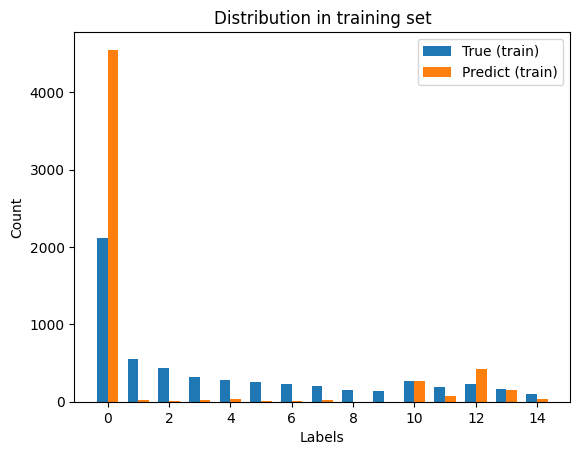

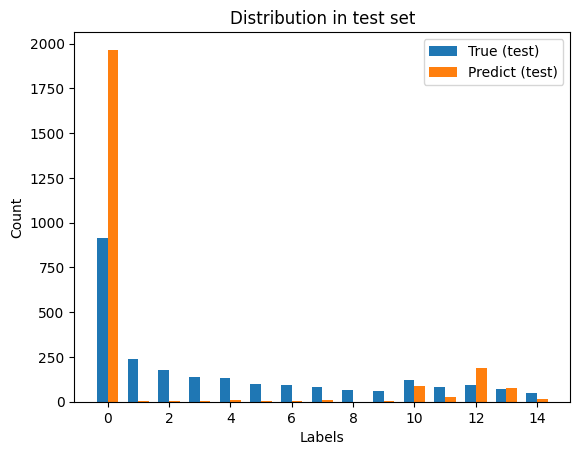